# **Germany Used Cars - Modelo Preditivo**

O mercado de automóveis nas últimas décadas se desenvolveu para um mercado com uma variedade imensa de modelos, marcas e categorias, com os mais diversos propósitos. Além disso, ainda há a atualiação de linhas de carros, com novos desingns e tecnologias. Para haver tantas opções que um consumidor pode escolher, também há demanda para isso. 

Nesse contexto, surgem mercados com propostas semelhantes, como marketplaces e mercados de carros usados. No entanto precificar um carro usado, ou carro novo que é vendido ao lado de um carro usado, não é uma tarefa simples, pois haverá diversos fatores que influenciaram o preço do carro, inclusive a forma como ele foi utilizado anteriormente, e o seu estado em relação a um modelo 0 quilômetro. Ou seja, conseguir prever o preço esperado de um carro dado alguns de seus atributos e estado pode ser de grande valor para um mercado de carros usados, ou até mesmo marketplaces.

Para realização de tal tarefa será utilizado um dataset com informações referentes ao AutoScout24, um dos maiores marketplaces de venda de carros da Alemanha.

## **Sobre os Dados**

Segundo a [fonte de dados](https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023), os dados foram obtidos por meio de um scrap de dados, que abrange carros fabricados de 1995 até 2023. 

Além disso, o dataset possui, originalmente, 15 colunas contendo informações como marca, modelo, cor, potência, consumo e preço.

### **Atribuição**

Os dados utilizados possuem a licença CC0, de dominio público, e foram disponibilizados por wspirat em [Kaggle](https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023) e tratam de informações sobre carros da [Autoscout24](https://www.autoscout24.de/).

**[Germany Used Cars Dataset 2023](https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023) by wspirat. The data is dedicated to the public domain under CC0.**

## **Objetivo**

Construção de um modelo preditivo para os preços do automóveis.

Não será utilizado um threshold para as métricas de performance, pois não foi houve qualquer contato prévio com os dados. Será selecionado o melhor algoritmo encontrado, posteriormente será realizada uma tentativa de calibração de hiperâmetros a esse algoritmo, caso possível.

## **Análise e Desenvolvimento do Modelo**

### **Preparação do ambiente**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import zscore
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RANSACRegressor, Ridge, Lasso, HuberRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from pprint import pprint

In [2]:
from platform import python_version
print("Versão Python utilizada:", python_version())

Versão Python utilizada: 3.11.3


In [3]:
import watermark.watermark as watermark
%load_ext watermark

In [4]:
%watermark --iversions

seaborn          : 0.12.2
pandas           : 2.0.3
re               : 2.2.1
scipy            : 1.11.1
category_encoders: 2.6.1
numpy            : 1.24.4
matplotlib       : 3.7.1



### **Carregando e Explorando Inicialmente os Dados**

In [5]:
dados = pd.read_csv('data.csv', engine = 'pyarrow', index_col = 0)

In [6]:
dados.dtypes

brand                        object
model                        object
color                        object
registration_date            object
year                         object
price_in_euro                object
power_kw                     object
power_ps                     object
transmission_type            object
fuel_type                    object
fuel_consumption_l_100km     object
fuel_consumption_g_km        object
mileage_in_km               float64
offer_description            object
dtype: object

In [7]:
dados.shape

(251079, 14)

In [8]:
dados.head(5)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
,,,,,,,,,,,,,,
0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.0,2.0 V6 TB
1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900,191,260,Manual,Petrol,,- (g/km),190000.0,"Q4 Allrad, 3.2L GTA"
2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900,110,150,Unknown,Petrol,,- (g/km),129000.0,ALFA ROME 916
3,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.0,2.0 16V Twin Spark L
4,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950,132,179,Manual,Petrol,"7,2 l/100 km",- (g/km),96127.0,"3.0i Super V6, absoluter Topzustand !"


Já é possível perceber que o dataset possui alguns dados faltantes. Algumas colunas que representam variáveis quantitativas estão formatadas como texto, isso é um indicativo, de dados faltantes, ou de caracteres indesejados. 

In [9]:
dados.isna().sum()

brand                         0
model                         0
color                         0
registration_date             0
year                          0
price_in_euro                 0
power_kw                      0
power_ps                      0
transmission_type             0
fuel_type                     0
fuel_consumption_l_100km      0
fuel_consumption_g_km         0
mileage_in_km               152
offer_description             0
dtype: int64

Aparentemente, a coluna `mileage_in_km` não é a única com dados nulos. No entanto, não parecem estar com caracteres que representam essa falta de informação. A melhor forma de descobrir quais são essas colunas é iniciando uma análise exploratória em profundidade nos dados, juntamente com a limpeza.

In [10]:
# tamanho do dataset para controle e verificação do impacto das alterações realizadas
tamanho_dataset_inicio = len(dados)

### **Análise Exploratória de Dados (EDA)**

Para iniciar a análise, as colunas serão separadas entre variáveis qualitativas, quantitativas, outras variáveis, que serão tratadas de forma separada, pois vão necessitar de maiores transformações e a própria variável target (price_in_euro).

In [11]:
var_quali = ['brand', 'model', 'color', 'transmission_type', 'fuel_type', 'offer_description']

var_quanti = ['power_kw', 'power_ps', 'mileage_in_km']

outras = ['registration_date', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'year']

target = 'price_in_euro'

In [12]:
def graficos_qualitativos(dataset, x, y):

    fig, axes = plt.subplots(1, 2, figsize = (24, 7))

    if len(dataset[x].value_counts()) < 7:
        ax = sns.countplot(data = dataset, x = dataset[x], palette = 'husl',
                           order = dataset[x].value_counts().index,
                           ax = axes[0])
        
        ax.set(yticklabels = [])
        ax.tick_params(left = False)
        
        ax.set(ylabel = 'Quantidade', title = "Quantidade de Carros por " + x)

    else:
        ax = sns.countplot(data = dataset, y = dataset[x], palette = 'husl',
                           order = dataset[x].value_counts().iloc[:10].index,
                           ax = axes[0])
        
        ax.set(xticklabels = [])
        ax.tick_params(bottom = False)
        
        ax.set(xlabel = 'Quantidade', title = "Quantidade de Carros por " + x)
        
    ax.bar_label(ax.containers[0])

    
    if len(dataset[x].value_counts()) < 7:
        ax = sns.boxplot(data = dataset, y = y, x = dataset[x],
                           order = dataset[x].value_counts().index,
                           ax = axes[1])
        plt.ticklabel_format(style = 'plain', axis = 'y')
        
    else:
        ax = sns.boxplot(data = dataset, y = dataset[x], x = y,
                           order = dataset[x].value_counts().iloc[:10].index,
                           ax = axes[1])
        
        plt.ticklabel_format(style = 'plain', axis = 'x')

    ax.set(xlabel = y , title = "Boxplot da variável" + y + " por " + x)
    
    
    fig.tight_layout()

In [13]:
def graficos_quantitativos(dataset, x, y, **kwargs):
    
    bins = kwargs.pop('bins', 'auto')
    
    fig, axes = plt.subplots(1, 2, figsize = (24, 7))
    
    ax = sns.histplot(dataset[x], ax =  axes[0], bins = bins)
    
    plt.ticklabel_format(style = 'plain', axis = 'x')
    
    ax.set(ylabel = 'Frequencia Absoluta', title = "Histograma " + x)

    ax = sns.scatterplot(x = dataset[x], y = dataset[y], ax = axes[1])
    
    plt.ticklabel_format(style = 'plain', axis = 'x')
    
    ax.set(title = "Scatter plot" + y + " x " + x)
    
    fig.tight_layout()

#### **Variável Target**

In [14]:
dados[target] = pd.to_numeric(dados[target], errors='coerce')

In [15]:
dados[target].isna().sum()

199

A variável target é a única variável que não pode ter valores ausentes para serem tratados com técnicas de inputação, pois é justamente a variável que se tenta explicar. Portanto, o mais adequado é realizar a exclusão das linhas.

In [16]:
dados = dados[dados[target].notnull()]

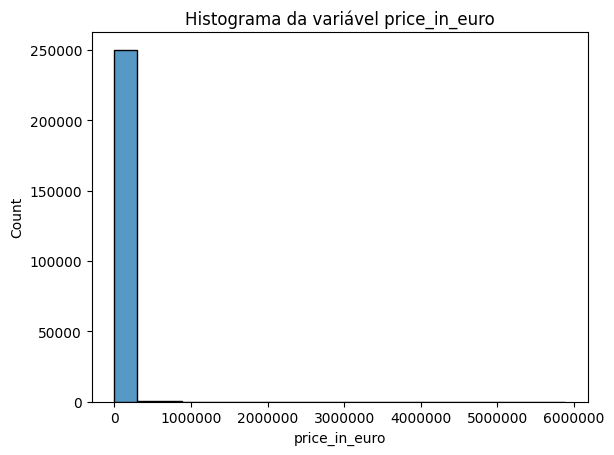

In [17]:
sns.histplot(dados[target], bins = 20)

plt.ticklabel_format(style = 'plain', axis = 'x')

plt.title("Histograma da variável " + target)

plt.show()

In [18]:
dados[target].describe().apply("{0:.2f}".format)

count     250880.00
mean       26137.53
std        36987.95
min          120.00
25%        11990.00
50%        19890.00
75%        29950.00
max      5890500.00
Name: price_in_euro, dtype: object

A variável target, possui 95% dos valores abaixo de 62650 euros. No entanto, há carros com valores superiores. Valores extremamente altos podem ser considerados outliers, como carros de colecionadores, por exemplo, ou carros de luxo.

Pode-se realizar algumas alterações na variável target, para ter um comportamento mais próximo de uma curva de Gauss. Isso vai facilitar o processo de tratamento dos outliers. 

Pode ser feita a transformação da variável utilizando a transformação Box Cox, que vai tornar a variável mais próxima de uma distribuição normal, com isso encontrar os outliers e realizar a exclusão.

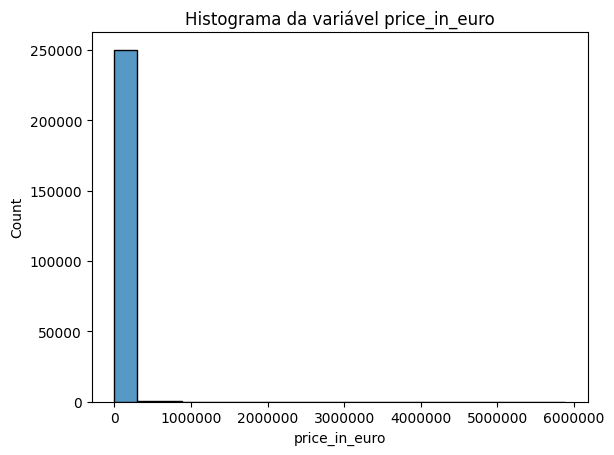

In [19]:
sns.histplot(dados[target], bins = 20)

plt.ticklabel_format(style = 'plain', axis = 'x')

plt.title("Histograma da variável " + target)

plt.show()

In [20]:
a, b = stats.boxcox(dados['price_in_euro'])
dados['boxcox_price_in_euro'] = a

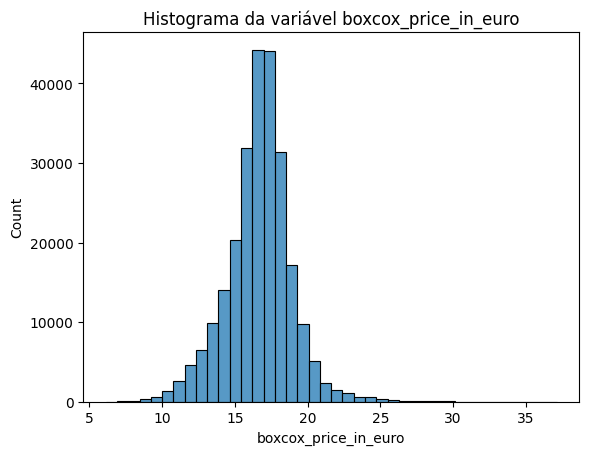

In [21]:
sns.histplot(dados['boxcox_price_in_euro'], bins = 40)

plt.ticklabel_format(style = 'plain', axis = 'x')

plt.title("Histograma da variável boxcox_price_in_euro")

plt.show()

Como a variável agora é próxima de uma distribuição normal pode-se utilizar o z-score para encontrar os outliers

In [22]:

outliers = zscore(dados['boxcox_price_in_euro']).abs() > 3

num_outliers = len(dados[outliers])

print("Total de outliers identificados:", num_outliers)
print("Percentual de outliers:", round(num_outliers / len(dados) * 100, 2), "%")

Total de outliers identificados: 2901
Percentual de outliers: 1.16 %


O volume de outliers encontrados é superior ao esperado para o modelo da distribuição normal. No entanto, essa diferença pode ser explicada pela presença de caudas mais alongadas que as esperadas na variável.

In [23]:
dados = dados[~outliers]

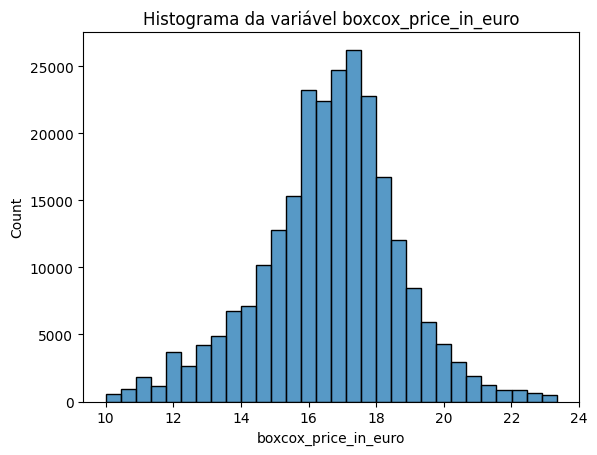

In [24]:
sns.histplot(dados['boxcox_price_in_euro'], bins = 30)

plt.ticklabel_format(style = 'plain', axis = 'x')

plt.title("Histograma da variável boxcox_price_in_euro")

plt.show()

#### **Variáveis Qualitativas**

In [25]:
print(var_quali)
print("\n Total de colunas a serem exploradas/tratadas:", len(var_quali))

['brand', 'model', 'color', 'transmission_type', 'fuel_type', 'offer_description']

 Total de colunas a serem exploradas/tratadas: 6


##### **Coluna brand**

In [26]:
len(dados['brand'].value_counts().head(15))

15

In [27]:
# Verificando se há dados nulos com a o caracter espaço, como na variável fuel_consumption_l_100km
len(dados[dados[var_quali[0]] == ""])

0

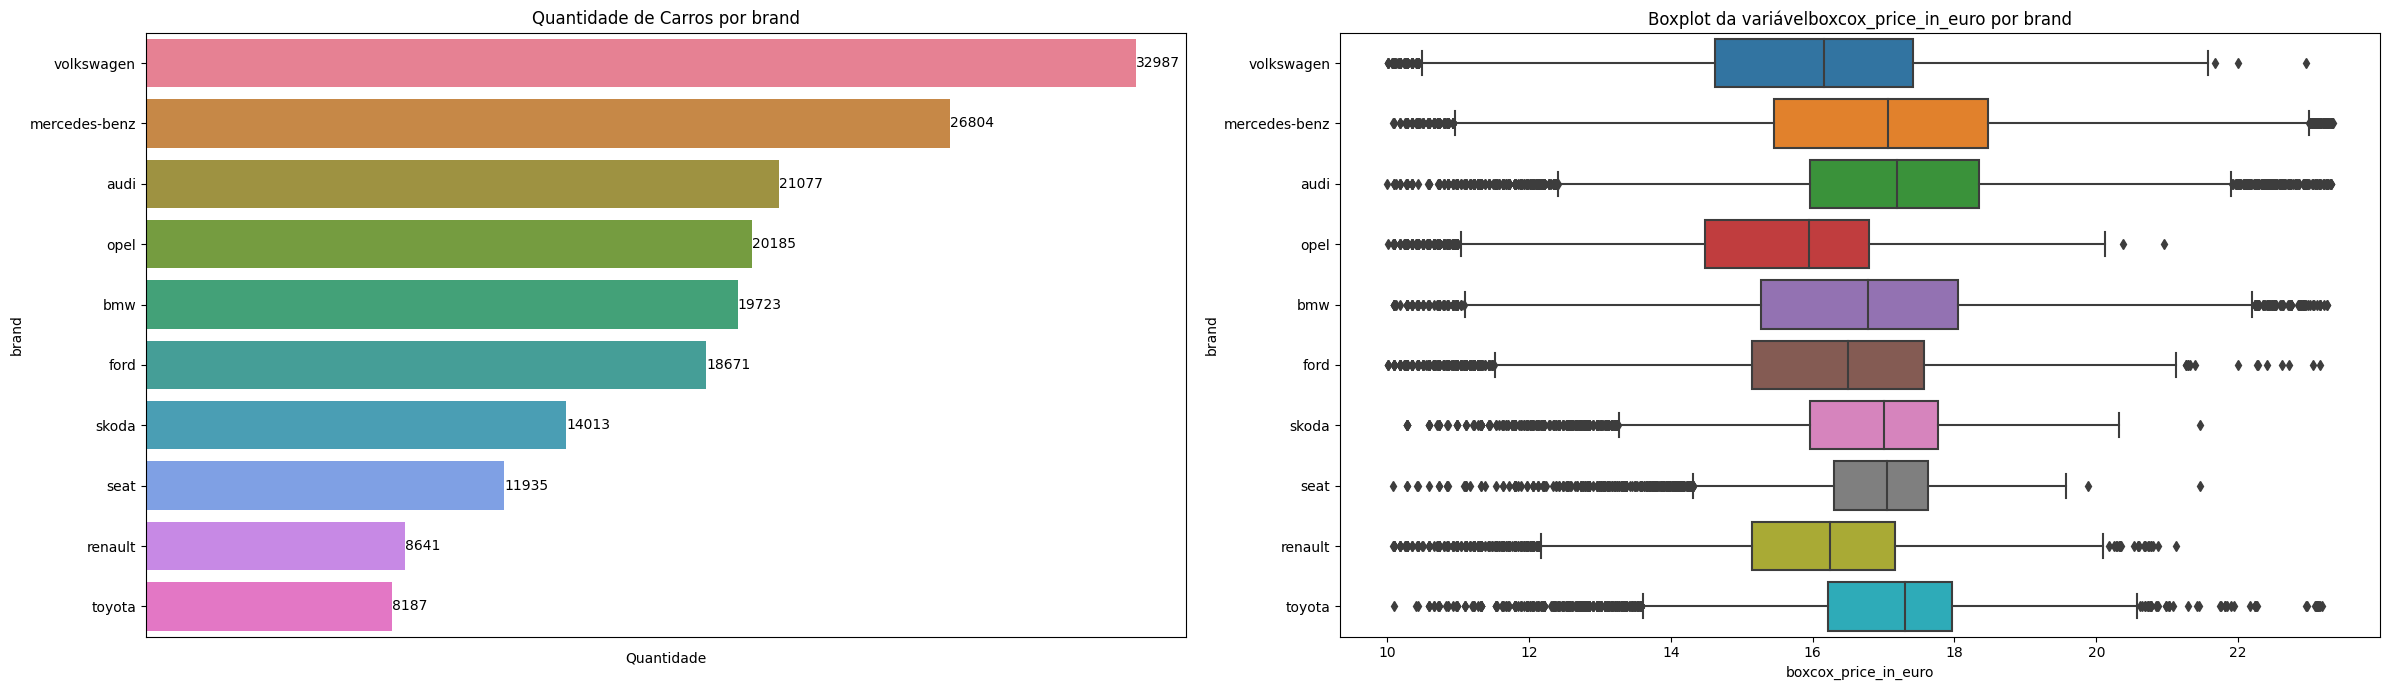

In [28]:
graficos_qualitativos(dados, var_quali[0], "boxcox_price_in_euro")

É visivel um comportamento de dados fora dos limites do boxplot, dentro das categorias. Esse comportamento, pelo volume de dados fora dos limites do boxplot demonstra uma alta variabilidade no preço dos carros por marca.

##### **Coluna Model**

In [29]:
len(dados[dados[var_quali[1]] == ""])

0

Como esperado, os modelos de carros mais presentes dizem respeito, justamente as marcas de carros mais presentes no dataset. ,

Nos boxplots, é visivel comportamentos alterados dependendo do modelo, isso pode ser explicado justamente pelo ano do carro, estado, procura, ou o próprio valor de revenda no mercado de usados.

##### **Coluna color**

In [30]:
len(dados[dados[var_quali[2]] == ""])

166

Há valores nulos na variável color, há um problema em tentar qualquer técnica de inputação na variável, por se tratar de uma variável categórica, não há como utilizar um método estátistico apropriado para isso. 

Logo, restam duas alternativas viáveis, adicionar uma nova categoria como "não informada", ou realizar a exclusão dos dados.

In [31]:
dados = dados[dados[var_quali[2]] != ""]

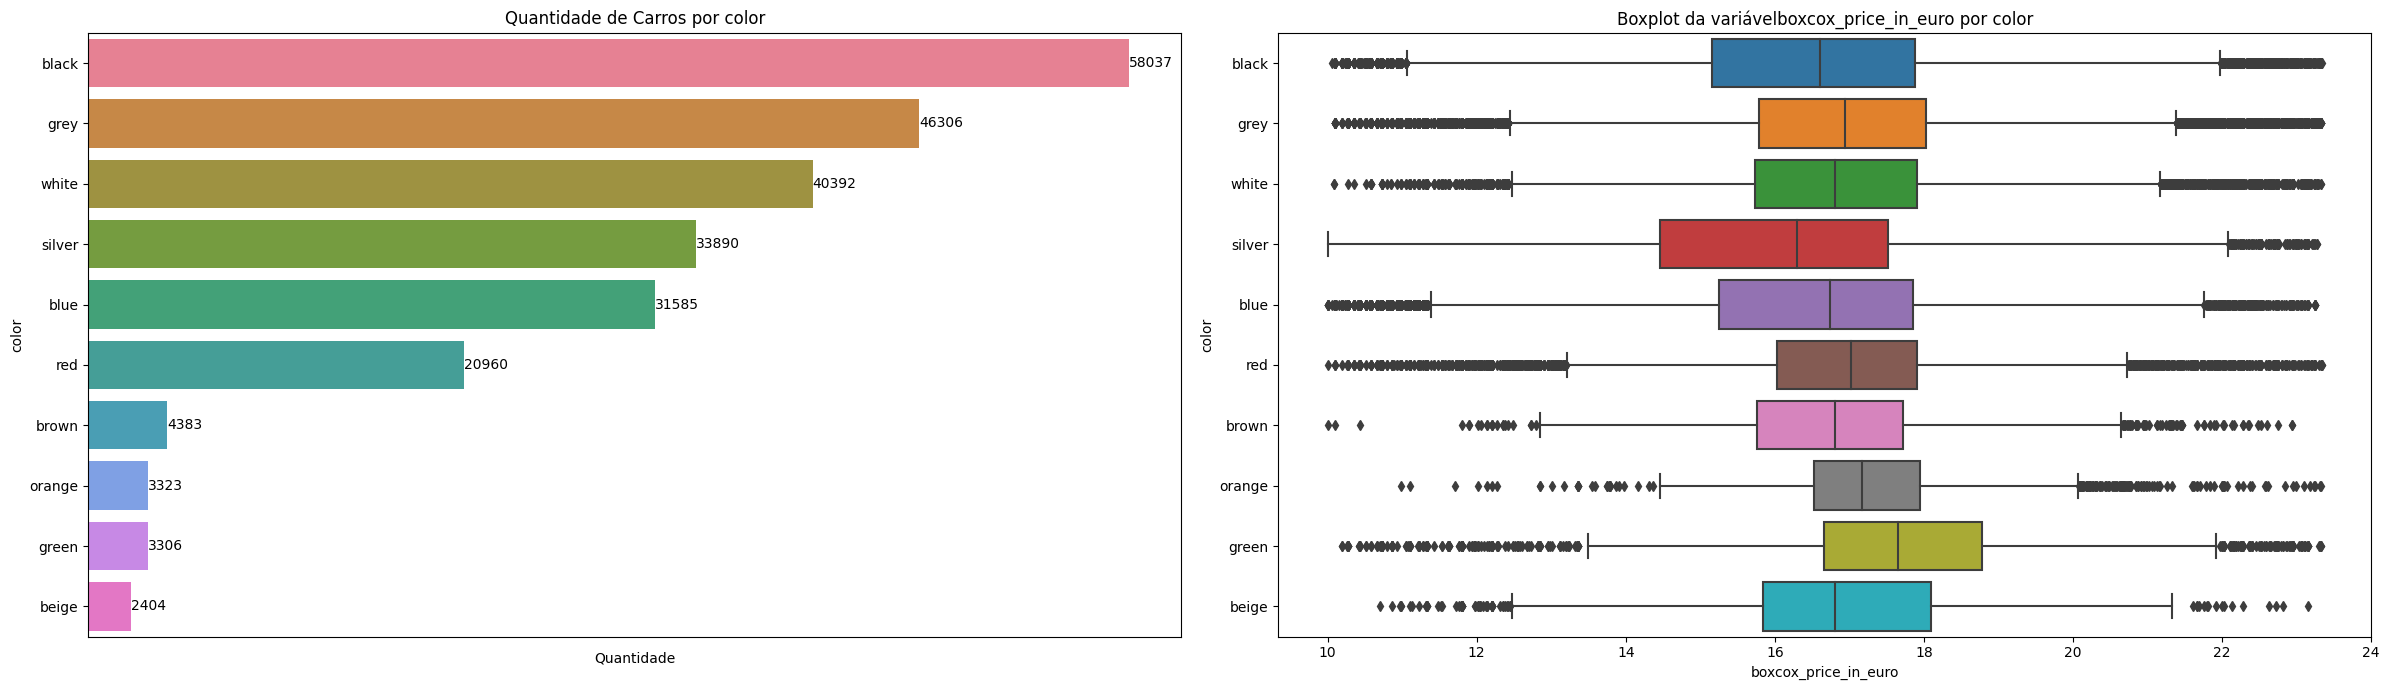

In [32]:
graficos_qualitativos(dados, var_quali[2], "boxcox_price_in_euro")

Mais uma vez todas categorias parecem apresentar um comportamento semelhante onde há maior densidade nos boxplots, e cores neutras parecem ser predominantes nos datasets, seguidas do azul e vermelho.

##### **Coluna transmission_type**

In [33]:
len(dados[dados[var_quali[3]] == ""])

0

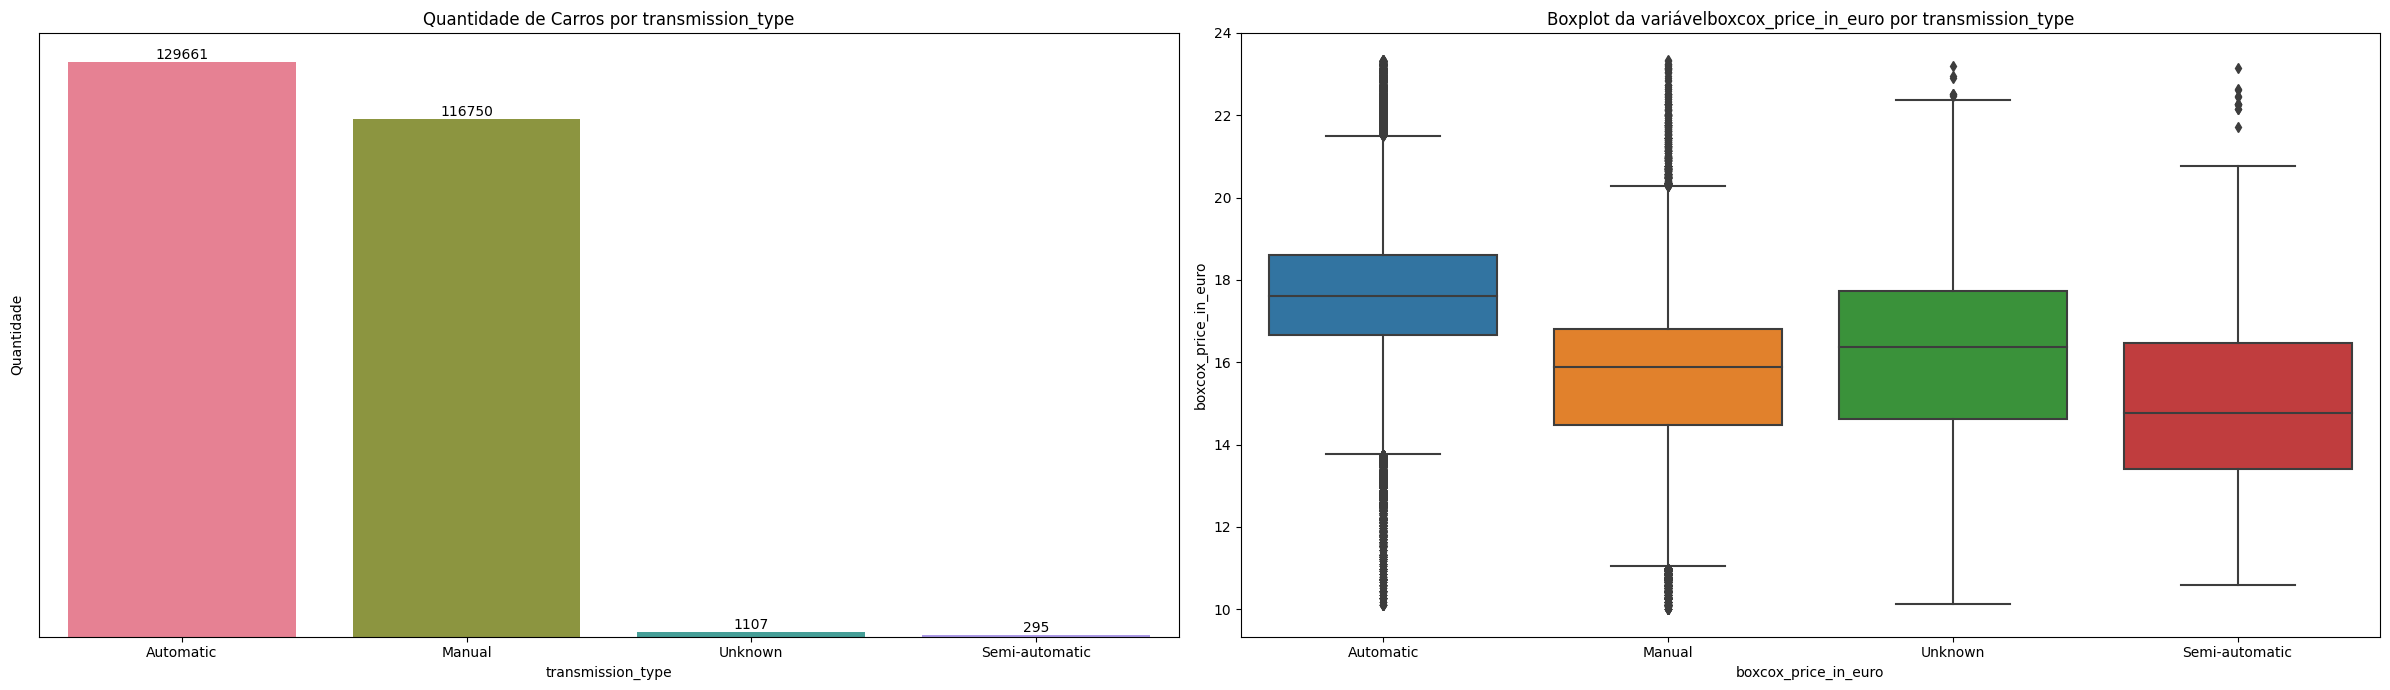

In [34]:
graficos_qualitativos(dados, var_quali[3], "boxcox_price_in_euro")

Carros de transmissão manual e semi-automatica tendem a ter preços mais baixos que carros de transmissão automática. Além disso, carros de tranmissão semi-automática aparecem com uma frequência muito menor, provavelmente pela baixa aderência das fabricantes.

##### **Coluna fuel_type**

In [35]:
len(dados[dados[var_quali[4]] == ""])

0

Carros hibridos à diesel, são em teste casso hibridos, então essa categoria pode ser transformada hibrido.

In [36]:
dados['fuel_type'].value_counts()

fuel_type
Petrol           140630
Diesel            86129
Hybrid            12519
Electric           5953
LPG                1243
CNG                 508
Diesel Hybrid       473
Other               178
Unknown              90
Hydrogen             80
Ethanol              10
Name: count, dtype: int64

In [37]:
dados['fuel_type'] = np.where(dados['fuel_type'] == 'Diesel Hybrid',
                              'Hybrid',
                              dados['fuel_type'])

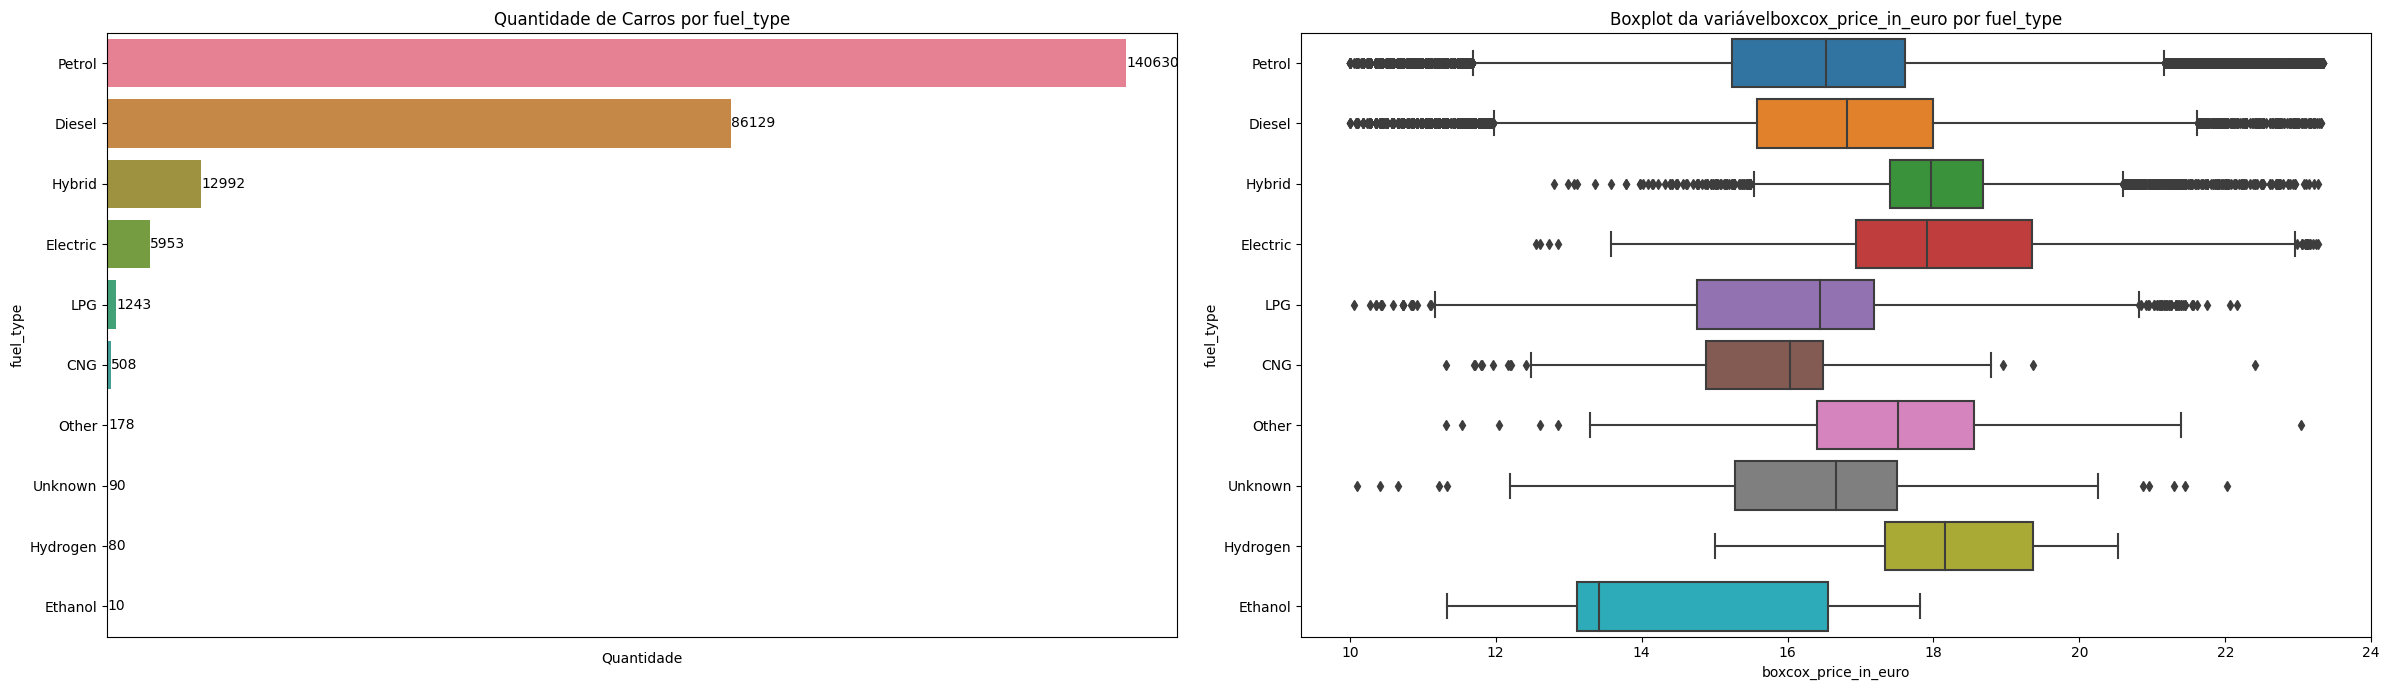

In [38]:
graficos_qualitativos(dados, var_quali[4], "boxcox_price_in_euro")

Carros a gasolina e disel são os mais comuns de serem encontrados. 

Carros a disel possuem limites de valores superiores mais altos que os carros à gasolina. No entanto, carros a gasolina possuem maior variabilidade de valor, com carros atingindo valores muito mais altos. O mesmo ocorre com carros hibridos. Apesar de carros elétricos possuerem uma tendência de valores maiores, eles possuem um comportamento de menor variabilidade, sem pontos tão distantes da faixa de maior concetração de valores.

##### **Coluna offer_description**

In [39]:
dados[var_quali[5]].nunique()

198501

A variável offer_description possui 198501 valores únicos, não faz sentido manter uma variável desse tipo no dataset, pois não será possível identificar um padrão dentro dela

In [40]:
dados.drop(var_quali[5], axis = 1, inplace = True)

#### **Variáveis Quantitativas**

In [41]:
print(var_quanti)
print("\n Total de colunas a serem exploradas/tratadas:", len(var_quanti))

['power_kw', 'power_ps', 'mileage_in_km']

 Total de colunas a serem exploradas/tratadas: 3


##### **Variável power_kw**

In [42]:
len(dados[dados[var_quanti[0]] == ""])

117

In [43]:
dados = dados.loc[dados[var_quanti[0]] != ""]

In [44]:
dados[var_quanti[0]] = dados.loc[:, var_quanti[0]].astype(int)

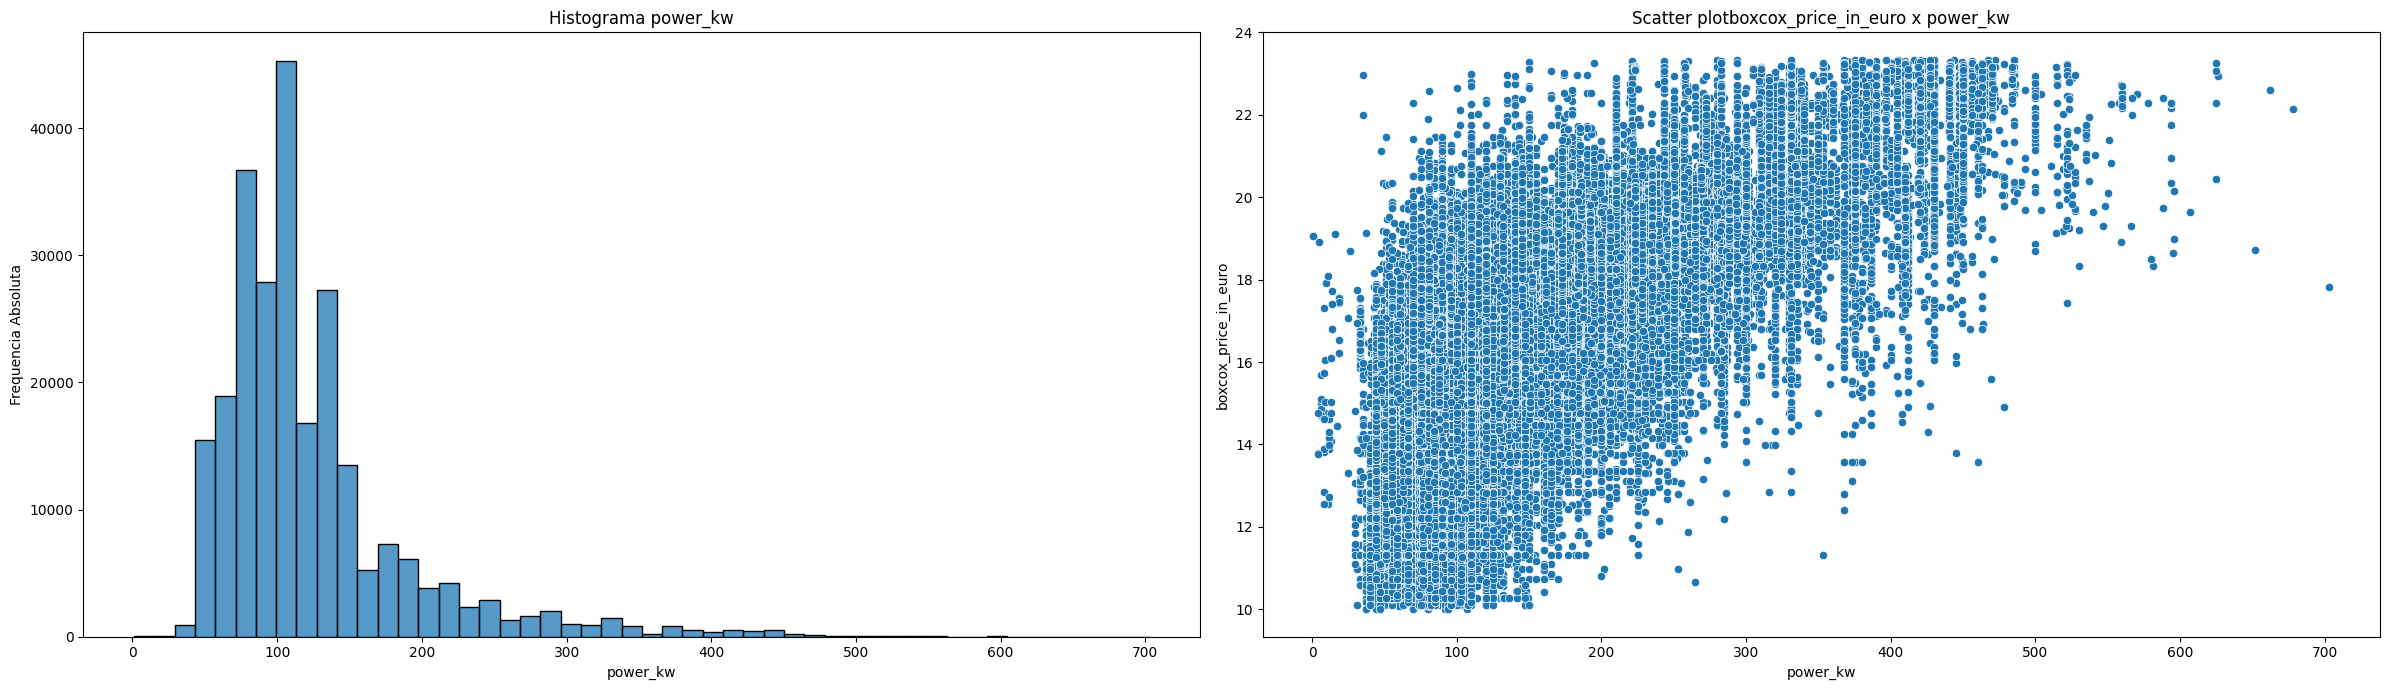

In [45]:
graficos_quantitativos(dados, var_quanti[0], 'boxcox_price_in_euro', bins = 50)

A variável `log_power_kw` possui, claramente, uma assimetria, que pode ser facilmente transformada em uma variável próxima da normal, aplicando a função logartimica aos dados.

In [46]:
dados.loc[:, 'log_power_kw'] = np.log(dados.power_kw)

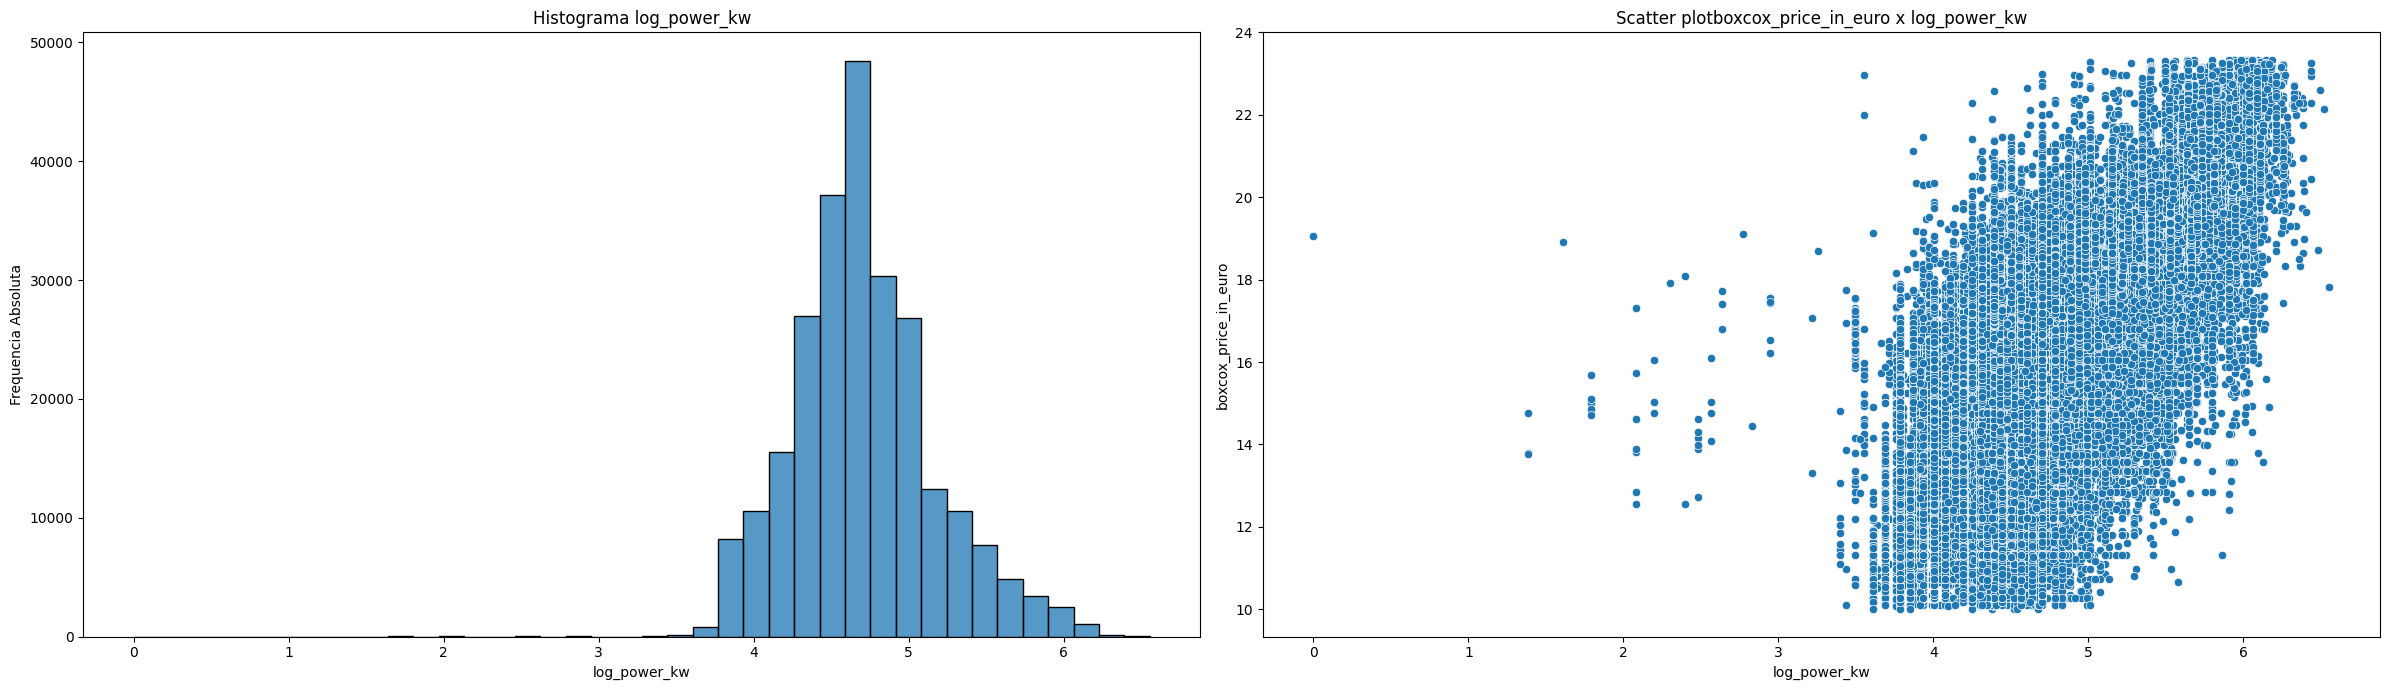

In [47]:
graficos_quantitativos(dados, 'log_power_kw', 'boxcox_price_in_euro', bins = 40)

In [48]:
# Remoção de outliers
dados = dados[dados['log_power_kw'] > 2]

##### **Variável power_ps**

In [49]:
len(dados[dados[var_quanti[1]] == ""])

0

In [50]:
dados[var_quanti[1]] = dados.loc[:, var_quanti[1]].astype(int)

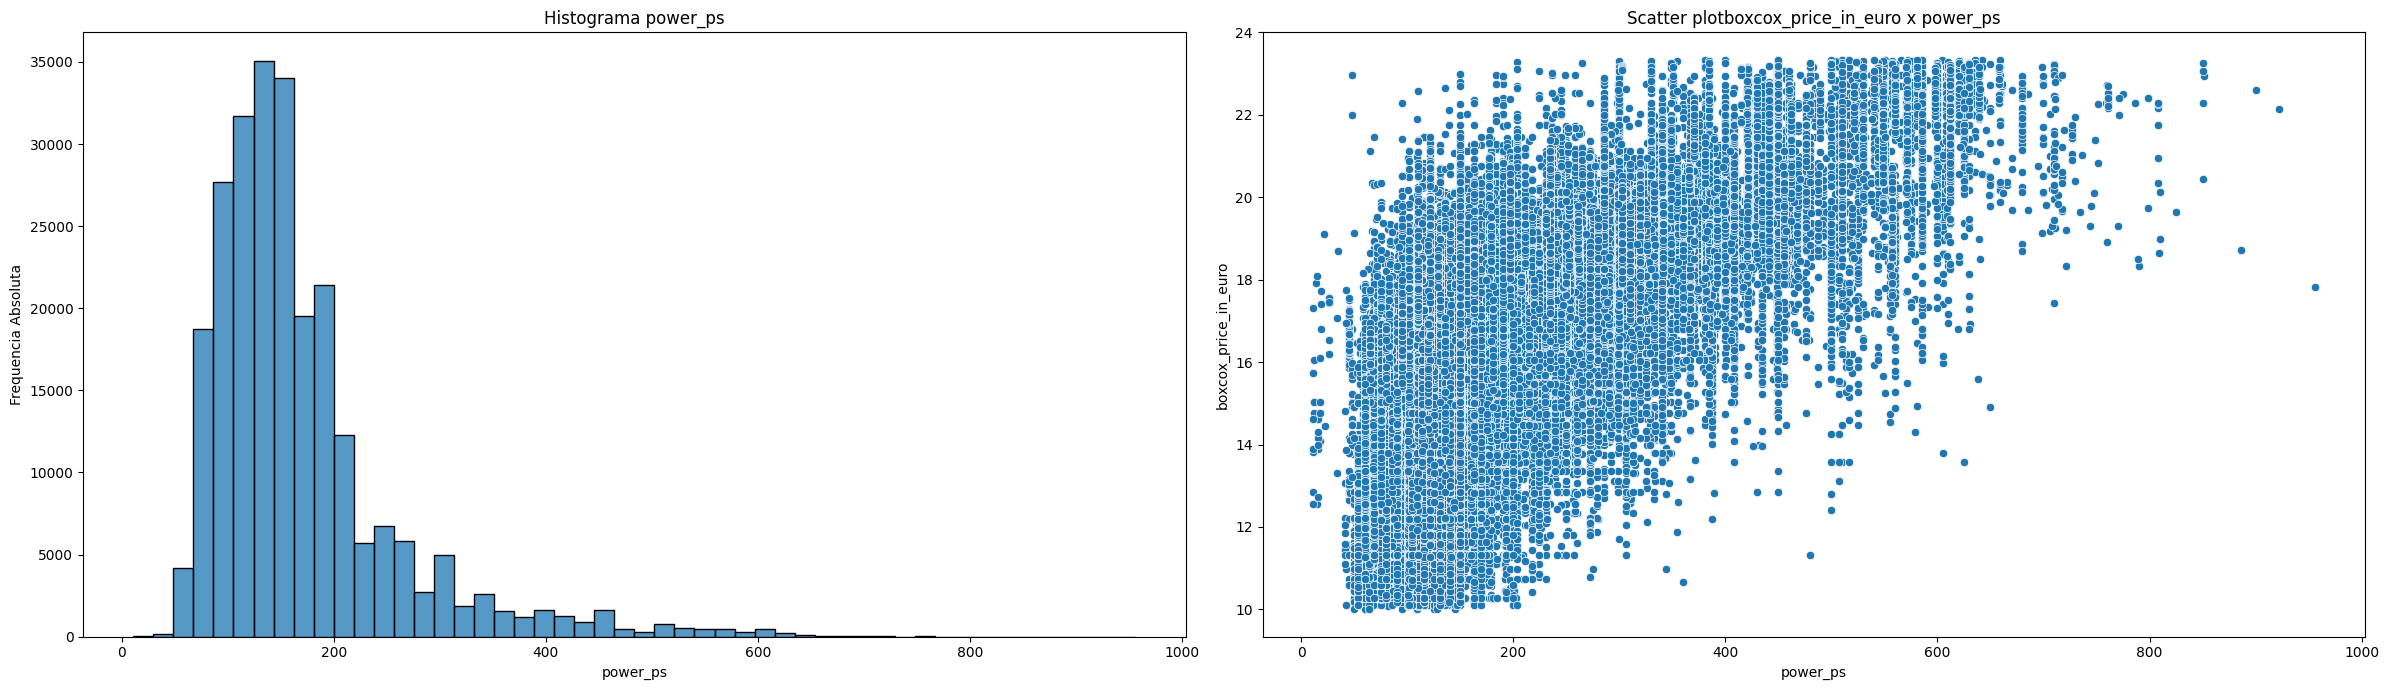

In [51]:
graficos_quantitativos(dados, var_quanti[1], "boxcox_price_in_euro", bins = 50)

É esperado que as variáveis `power_kw` e `power_ps` possuam uma correlação de 1, pois se tratam da mesma informação, expressa em medidas diferentes.

##### **Variável mileage_in_km**

In [52]:
len(dados[dados[var_quanti[2]] == ""])

0

In [53]:
dados[var_quanti[2]].isna().sum()

60

In [54]:
dados.head(10)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,boxcox_price_in_euro,log_power_kw
,,,,,,,,,,,,,,,
0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300.0,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.0,10.435385,4.997212
1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900.0,191,260,Manual,Petrol,,- (g/km),190000.0,17.401157,5.252273
2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900.0,110,150,Unknown,Petrol,,- (g/km),129000.0,13.750141,4.700480
3,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900.0,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.0,13.315961,4.700480
4,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950.0,132,179,Manual,Petrol,"7,2 l/100 km",- (g/km),96127.0,16.525102,4.882802
5,alfa-romeo,Alfa Romeo Spider,red,04/1996,1996,7900.0,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,47307.0,14.448903,4.700480
6,alfa-romeo,Alfa Romeo 145,red,12/1996,1996,3500.0,110,150,Manual,Petrol,"8,8 l/100 km",210 g/km,230000.0,12.549358,4.700480
7,alfa-romeo,Alfa Romeo 164,black,07/1996,1996,5500.0,132,179,Manual,Petrol,"13,4 l/100 km",320 g/km,168000.0,13.585075,4.882802
8,alfa-romeo,Alfa Romeo Spider,black,07/1996,1996,8990.0,141,192,Manual,Petrol,11 l/100 km,265 g/km,168600.0,14.764796,4.948760


In [55]:
dados = dados.loc[(dados[var_quanti[2]] != "") & (dados[var_quanti[2]].notnull())]

In [56]:
dados[var_quanti[2]] = dados.loc[:, var_quanti[2]].astype(float)

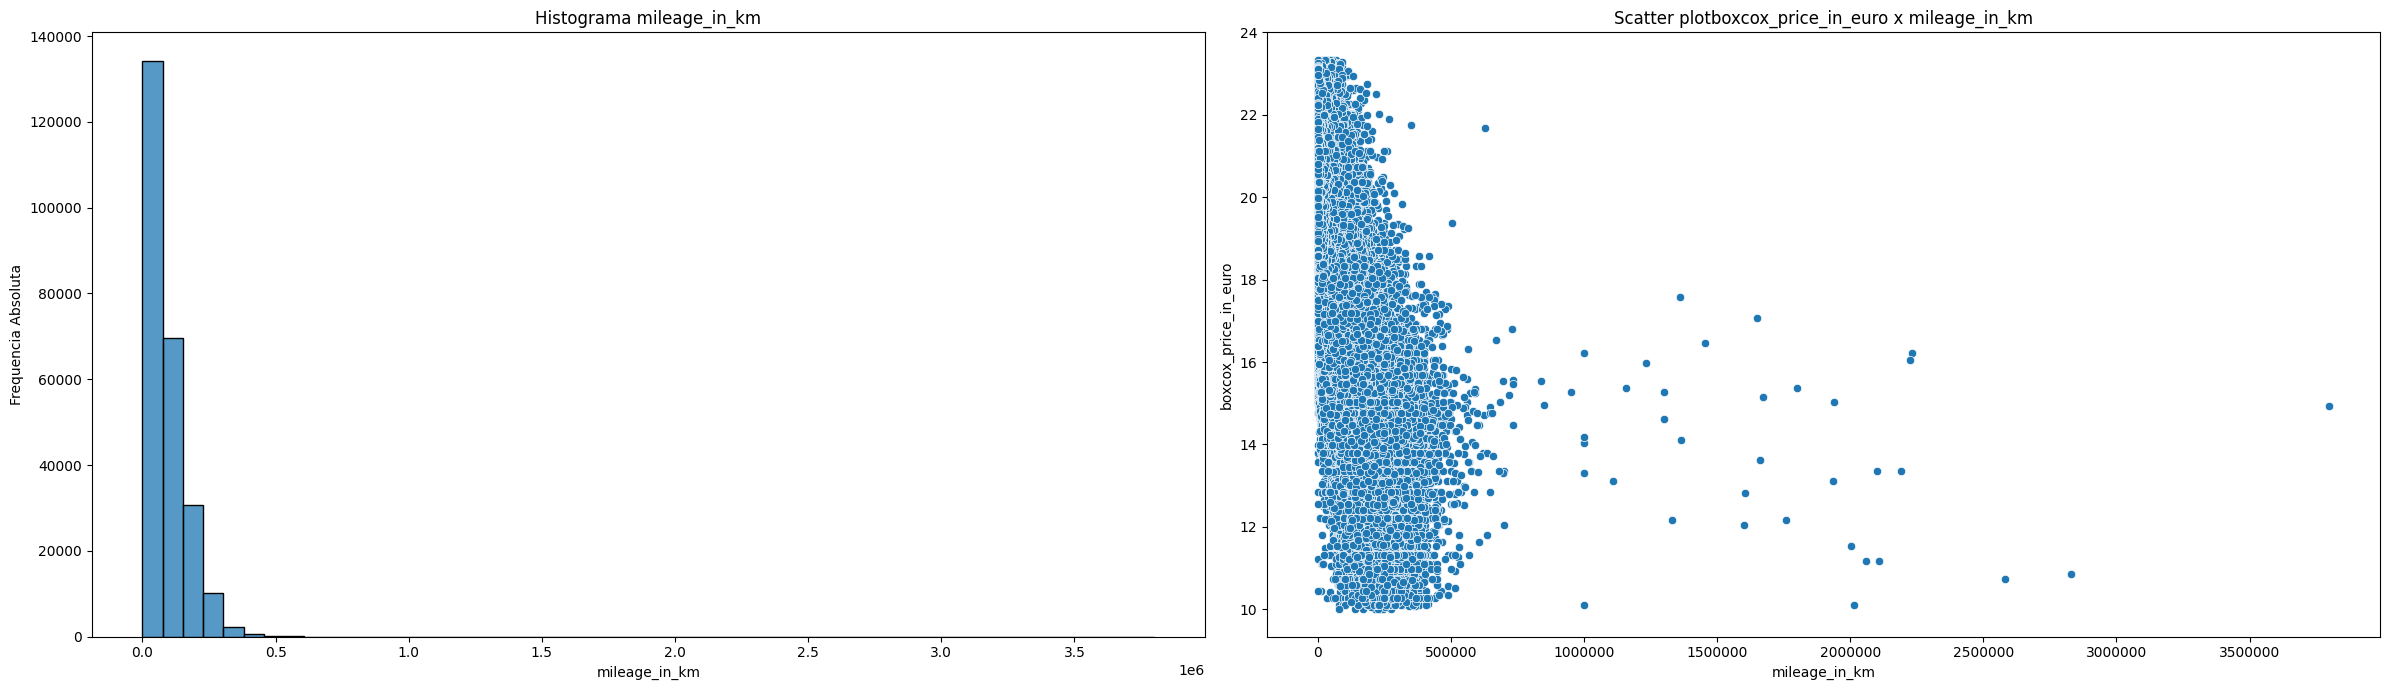

In [57]:
graficos_quantitativos(dados, 'mileage_in_km', 'boxcox_price_in_euro', bins = 50)

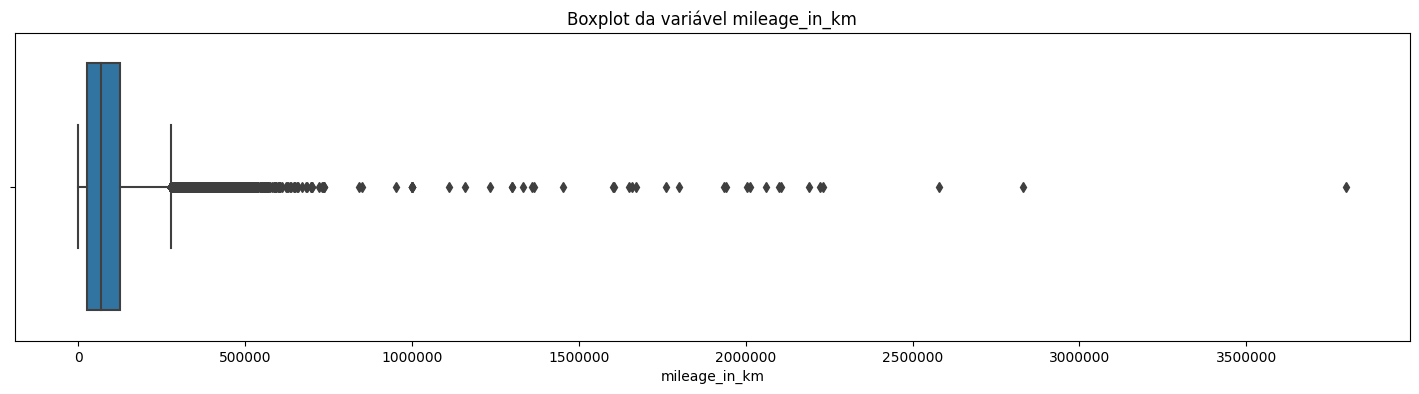

In [58]:
plt.figure(figsize = (18, 4))

sns.boxplot(data = dados, x = 'mileage_in_km')

plt.ticklabel_format(style = 'plain', axis = 'x')

plt.title("Boxplot da variável mileage_in_km")

plt.show()

Pelo boxplot da variável fica claro perceber outliers, onde há pontos de dados sem agrupamento de dados próximos, como os valores acima de 2.500.000 quilômetros rodados. Além disso, a variável possui uma distribuição com comportamento assimétrico muito forte.

In [59]:
dados = dados[dados['mileage_in_km'] < 2500000]

In [60]:
dados.loc[:, 'sqrt_mileage_in_km'] = np.sqrt(dados.mileage_in_km)

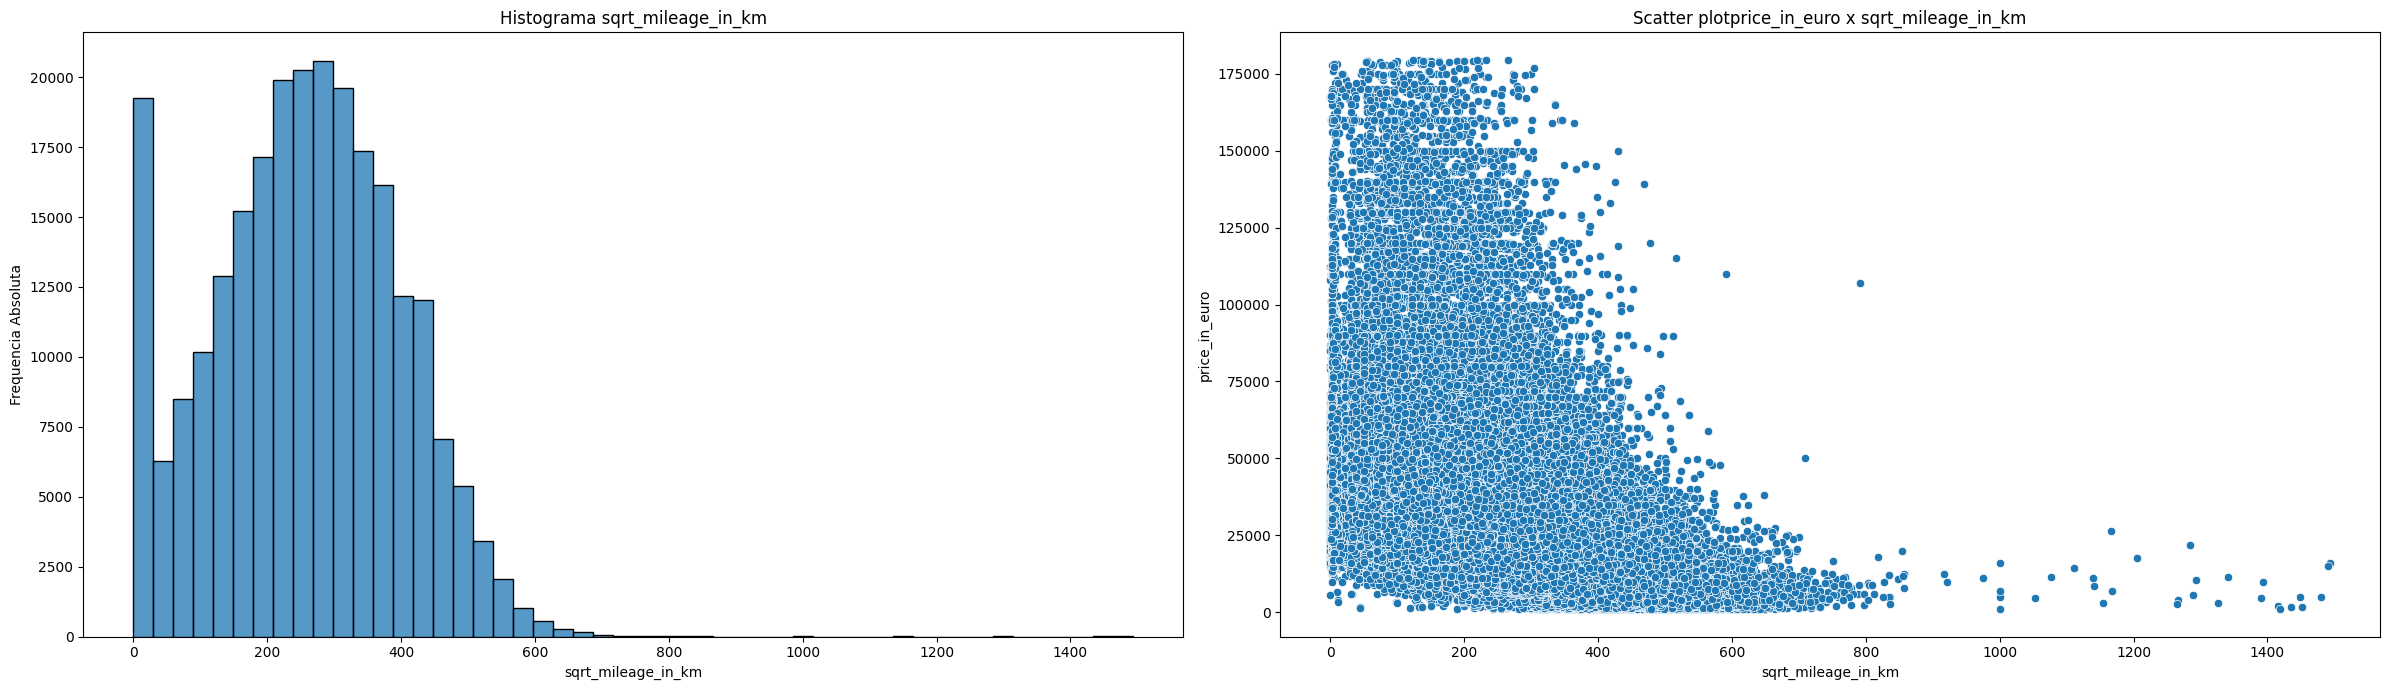

In [61]:
graficos_quantitativos(dados, 'sqrt_mileage_in_km', target, bins = 50)

Agora o gráfico se assemelha mais a uma distribuição normal.

#### **Outras Variáveis**

In [62]:
print(outras)
print("Quantidade de variáveis a serem trabalhadas: ", len(outras))

['registration_date', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'year']
Quantidade de variáveis a serem trabalhadas:  4


##### **Coluna registration_date**

In [63]:
len(dados[dados[outras[0]] == ""])

0

In [64]:
dados[outras[0]].dtypes

dtype('O')

A variável registration_date não parece possuir dados nulos. No entanto, não está formatada como data.

In [65]:
dados.head()

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,boxcox_price_in_euro,log_power_kw,sqrt_mileage_in_km
,,,,,,,,,,,,,,,,
0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300.0,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.0,10.435385,4.997212,400.624512
1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900.0,191,260,Manual,Petrol,,- (g/km),190000.0,17.401157,5.252273,435.889894
2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900.0,110,150,Unknown,Petrol,,- (g/km),129000.0,13.750141,4.700480,359.165700
3,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900.0,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.0,13.315961,4.700480,435.315977
4,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950.0,132,179,Manual,Petrol,"7,2 l/100 km",- (g/km),96127.0,16.525102,4.882802,310.043545


In [66]:
dados[outras[0]] = pd.to_datetime('01 /' + dados[outras[0]].astype(str), dayfirst = True)

In [67]:
serie = dados.loc[:, ["boxcox_price_in_euro", outras[0]]]

serie['contagem'] = 1

serie = serie.groupby(outras[0]).sum().reset_index()

serie['boxcox_preco_medio'] = serie['boxcox_price_in_euro'] / serie['contagem']

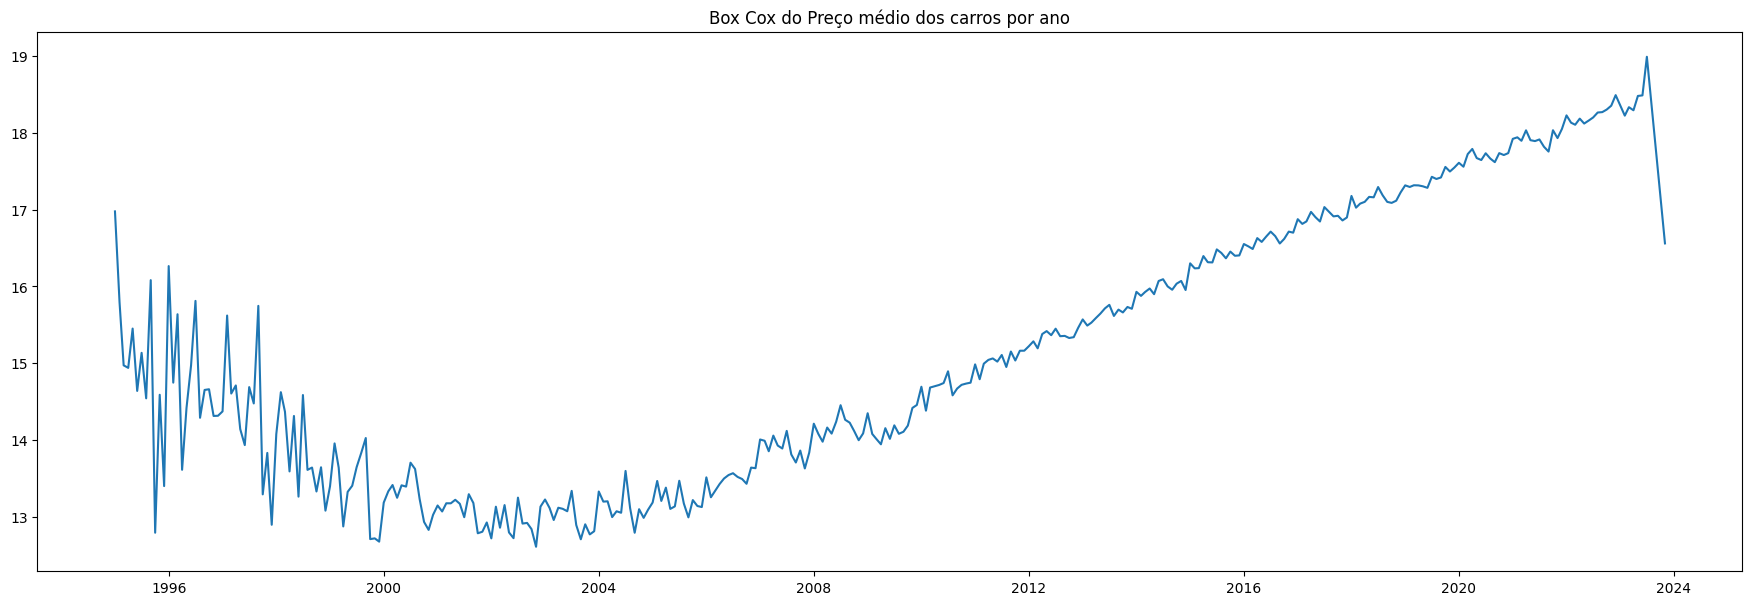

In [68]:
plt.figure(figsize = (22, 7))

plt.plot(serie[outras[0]], serie['boxcox_preco_medio'])

plt.ticklabel_format(style = 'plain', axis = 'y')

plt.title("Box Cox do Preço médio dos carros por ano");

In [69]:
# Quantidade de carros por ano no mercado, com valor acima o percentil 95 (69 mil euros)
dados[dados['boxcox_price_in_euro'] > dados['boxcox_price_in_euro'].quantile(0.95)][['year', 'boxcox_price_in_euro']].groupby('year').count().reset_index().sort_values('year', ascending = False).head(15)

,year,boxcox_price_in_euro
28,2023,2739
27,2022,2359
26,2021,1371
25,2020,1045
24,2019,1400
23,2018,1081
22,2017,676
21,2016,423
20,2015,300
19,2014,195


De 1996 até 2005 é possível perceber uma queda no preço médio dos carros usados no mercado alemão. Posteriormente a essa data o mercado passou apresentar um preço médio mais alto para os carros. 

Conforme visto inicialmente, 75% dos valores dos carros são de até 30 mil. Essa evolução no preço pode ser explicada pelo surgimento de carros de luxo e mais valorizados nesse mercado, conforme a tabela corrobora.

##### **Colunas fuel_consumption_l_100km e fuel_consumption_g_km**

In [70]:
len(dados[dados['fuel_consumption_l_100km'] == ""])

26252

In [71]:
print("O percentual de dados faltantes na coluna fuel_consumption_l_100km é de:",  round((len(dados[dados['fuel_consumption_l_100km'] == ""])/len(dados)) * 100, 2), "%")

O percentual de dados faltantes na coluna fuel_consumption_l_100km é de: 10.6 %


O volume de dados faltantes na coluna exige tratamento, excluir as linhas não é a melhor decisão. No entanto, deve ser levado em consideração a categoria se o carro é elétrico, todos os carros pertencentes a essa categoria estão sem o consumo informado. Tratar esse problema, buscando não modificar tanto a variável é relativamente trabalhoso, e pode ser um tanto confuso. 

Em um ambiente real, a melhor prática a se fazer seria retornar os dados para quem os coletou e solicitar a validação nesses dados, e caso necessário complementar com novos dados.

Antes de tudo é necessário realizar a remoção de caracteres indesejados da coluna, para posteriormente tomar-se uma decisão.

Posteriormente, os valores da coluna `fuel_consumption_g_km`  serão convertidos para `fuel_consumption_l_100km` para os valores missing, posteriormente utilizando a cálculo de consumo energético para consumo de gasolina equivalente. Caso ainda haja valores faltantes será utilizada a mediana por modelo do carro e tipo de combustível, com o intuito de não generalizar a inputação utilizando somente 1 valor, e ao mesmo tempo evitar que outliers influenciem o resultado.

In [72]:
dados[dados['fuel_type'] == 'Electric']

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,boxcox_price_in_euro,log_power_kw,sqrt_mileage_in_km
,,,,,,,,,,,,,,,,
16552,audi,Audi e-tron,beige,2019-09-01,2019,51888.0,300,408,Automatic,Electric,,359 km Reichweite,84800.0,19.472756,5.703782,291.204396
16559,audi,Audi e-tron,beige,2019-07-01,2019,53990.0,300,408,Automatic,Electric,,359 km Reichweite,51000.0,19.589145,5.703782,225.831796
16561,audi,Audi e-tron,beige,2019-11-01,2019,54870.0,300,408,Automatic,Electric,,0 g/km,82814.0,19.636663,5.703782,287.774217
16571,audi,Audi e-tron,beige,2019-12-01,2019,61989.0,300,408,Automatic,Electric,,0 g/km,55990.0,19.997650,5.703782,236.622062
16579,audi,Audi e-tron,blue,2019-02-01,2019,32930.0,300,408,Automatic,Electric,,359 km Reichweite,84300.0,18.172138,5.703782,290.344623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251033,volvo,Volvo C40,black,2023-05-01,2023,52890.0,170,231,Automatic,Electric,,400 km Reichweite,8.0,19.528757,5.135798,2.828427
251037,volvo,Volvo XC40,black,2023-04-01,2023,49900.0,170,231,Automatic,Electric,,0 g/km,14900.0,19.358701,5.135798,122.065556
251048,volvo,Volvo C40,black,2023-01-01,2023,51990.0,170,231,Automatic,Electric,,0 g/km,2106.0,19.478501,5.135798,45.891176


In [73]:
dados['fuel_consumption_l_100km'].replace("", np.nan, inplace = True)

dados['fuel_consumption_l_100km'] = dados['fuel_consumption_l_100km'].str.replace(r' l/100 km', '', regex = True)
dados['fuel_consumption_l_100km'] = pd.to_numeric(dados['fuel_consumption_l_100km'].str.replace(",", "."), errors = 'coerce')

In [74]:
dados['fuel_consumption_g_km'] = dados['fuel_consumption_g_km'].str.replace(r' g/km', '', regex = True)

In [75]:
dados[['fuel_consumption_g_km', 'temp']] = dados['fuel_consumption_g_km'].str.split(n = 1, expand = True)

dados['fuel_consumption_g_km'] = pd.to_numeric(dados['fuel_consumption_g_km'].str.replace(",", "."), errors = 'coerce')

dados['temp'] = np.where(dados['temp'].isnull() &
                         dados['fuel_consumption_g_km'].notnull(),
                         '(g/km)',
                         dados['temp'])

In [76]:
dados['temp'].value_counts()

temp
(g/km)           242429
km Reichweite      4287
km (Ort)              8
Name: count, dtype: int64

In [77]:
# Convertendo fuel_consumption_g_km para fuel_consumption_l_100km nos dados faltantes

dados['fuel_consumption_l_100km'] = np.where(((dados['temp'] == "(g/km)") &
                                             (dados['fuel_consumption_g_km'].notnull()) &
                                             (dados['fuel_consumption_l_100km'].isnull())),
                                             round(dados['fuel_consumption_g_km'].astype(float) * 0.043103448275862, 2),
                                             dados['fuel_consumption_l_100km'])

In [78]:
dados['fuel_consumption_g_km'].isna().sum()

35897

Para converter a medida de `fuel_consumption_g_km` em `fuel_consumption_l_100km` para carros elétricos pode-se se usar a conversão para consumo de gasolina equivalente. Antes de realizar a inputação, para evitar distorções na variável `fuel_consumption_l_100km`, só serão considerados carros que sejam elétricos e que possuam autonomia acima de 100 km, caso contrário surgirá diversos outliers na variável, o que interfirirá negativamente no dataset e treinamento do modelo.

Será necessário buscar informações sobre o custo do combustível e da energia na Alemanha, é possível realizar isso realizando webscraping. No entanto, isso fugiria do escopo do projeto aqui proposto. Como alternativa, serão utilizadas variáveis, com o valor atual da energia e combustível na Alemanha. Ou seja, com o tempo essa informação poderá ser diferente, mas na data atual é um valor confiável.

A informação será obtida do portal www.globalpetrolprices.com.

A coluna parece ter valores errados, uma vez que aparece autonomia de 1 km por ciclo da bateria. Para realizar o procedimento seguinte é importante validar essa informação.

In [79]:
dados[(dados['fuel_type'] == 'Electric') & (dados['temp'] == 'km Reichweite')]['fuel_consumption_g_km'].describe()

count    2984.000000
mean      345.601888
std       120.943016
min         1.000000
25%       250.000000
50%       344.000000
75%       440.000000
max       724.000000
Name: fuel_consumption_g_km, dtype: float64

In [80]:
dados['fuel_consumption_g_km'] = np.where(dados['fuel_consumption_g_km'] < 100,
                                          np.nan,
                                          dados['fuel_consumption_g_km'])

In [81]:
# fonte: www.globalpetrolprices.com

energia_hora_euro = 0.563
gasolina_euro = 1.786

In [82]:
# descrição estátistica da variável antes da inputação por conversão

dados['fuel_consumption_l_100km'].describe()

count    228965.000000
mean          5.853998
std           2.698266
min           0.000000
25%           4.800000
50%           5.600000
75%           6.700000
max         173.000000
Name: fuel_consumption_l_100km, dtype: float64

In [83]:
dados['consumo_eletrico'] = np.where((dados['temp'] != '(g/km)') &
                                     (dados['fuel_consumption_l_100km'].isnull()) &
                                     (dados['fuel_type'] != 'Hybrid'),
                                     round((((dados['power_kw'] * 100) / dados['fuel_consumption_g_km']) * energia_hora_euro) / gasolina_euro, 2),
                                     np.nan)

dados['fuel_consumption_l_100km'] = np.where(dados['consumo_eletrico'].notnull(),
                                             dados['consumo_eletrico'],
                                             dados['fuel_consumption_l_100km'])

In [84]:
# descrição estátistica da variável depois da inputação por conversão

dados['fuel_consumption_l_100km'].describe()

count    231895.000000
mean          5.953935
std           2.923437
min           0.000000
25%           4.800000
50%           5.700000
75%           6.800000
max         173.000000
Name: fuel_consumption_l_100km, dtype: float64

In [85]:
dados['fuel_consumption_l_100km'].isna().sum()

15725

In [86]:
# inputação pela mediana por agrupamento do modelo do carro e tipo de combustível para os faltantes

dados['fuel_consumption_l_100km'] = dados['fuel_consumption_l_100km'].fillna(dados.groupby('model')['fuel_consumption_l_100km'].transform('median'))
dados['fuel_consumption_l_100km'] = dados['fuel_consumption_l_100km'].fillna(dados.groupby('fuel_type')['fuel_consumption_l_100km'].transform('median'))

In [87]:
dados['fuel_consumption_l_100km'].isna().sum()

0

Não há mais dados faltantes na variável, e para todos os carros a medida de consumo está em consumo litros por 100 km rodados. Agora é possível remover as demais variáveis que, ou possuem um significado semelhante, ou foram utilizadas temporariamente na inputação.

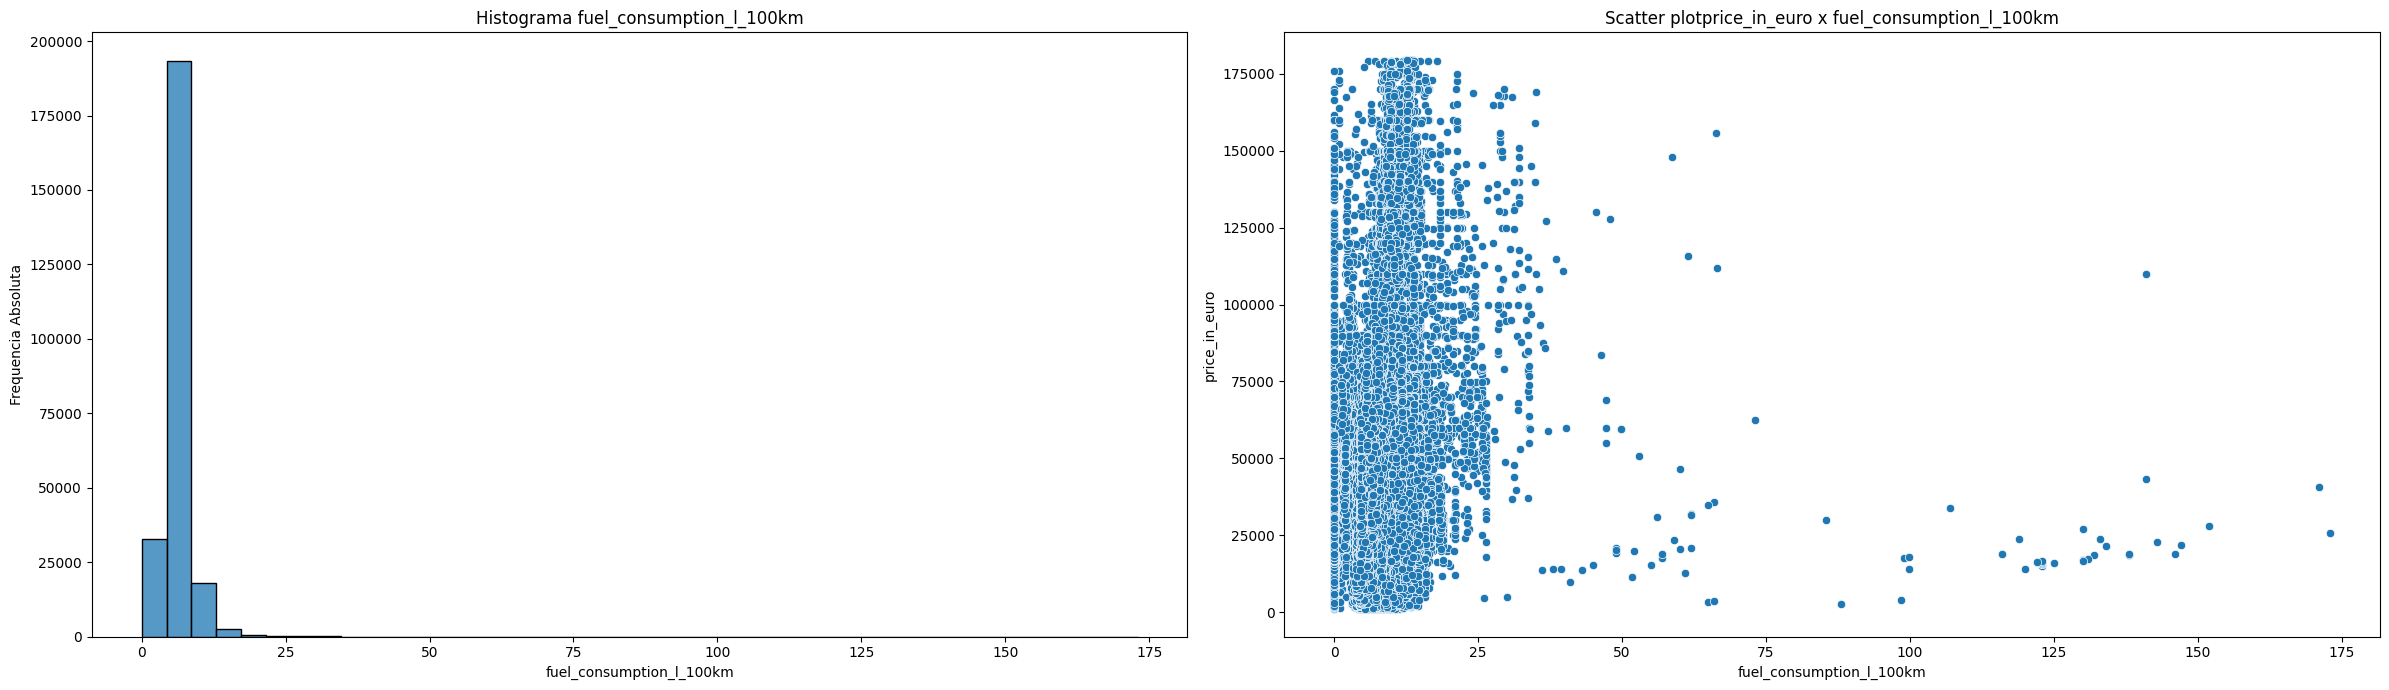

In [88]:
graficos_quantitativos(dados, 'fuel_consumption_l_100km', target, bins = 40)

Como visto no decorrer da limpeza de dados, a maior concentração de dados da variável está em dados abaixo de 40 litros para 100 quilômetros. Além disso, parece haver alguma correlação positiva entre preço e consumo, em consumos de até 25 litros para 100 quilômetros.

In [89]:
dados.drop(['fuel_consumption_g_km', 'temp', 'consumo_eletrico'], axis = 1, inplace = True)

##### **Coluna Year**

In [90]:
dados

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km,boxcox_price_in_euro,log_power_kw,sqrt_mileage_in_km
,,,,,,,,,,,,,,,
0,alfa-romeo,Alfa Romeo GTV,red,1995-10-01,1995,1300.0,148,201,Manual,Petrol,10.90,160500.0,10.435385,4.997212,400.624512
1,alfa-romeo,Alfa Romeo 164,black,1995-02-01,1995,24900.0,191,260,Manual,Petrol,10.30,190000.0,17.401157,5.252273,435.889894
2,alfa-romeo,Alfa Romeo Spider,black,1995-02-01,1995,5900.0,110,150,Unknown,Petrol,9.20,129000.0,13.750141,4.700480,359.165700
3,alfa-romeo,Alfa Romeo Spider,black,1995-07-01,1995,4900.0,110,150,Manual,Petrol,9.50,189500.0,13.315961,4.700480,435.315977
4,alfa-romeo,Alfa Romeo 164,red,1996-11-01,1996,17950.0,132,179,Manual,Petrol,7.20,96127.0,16.525102,4.882802,310.043545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251074,volvo,Volvo XC40,white,2023-04-01,2023,57990.0,192,261,Automatic,Hybrid,6.20,1229.0,19.799776,5.257495,35.057096
251075,volvo,Volvo XC90,white,2023-03-01,2023,89690.0,173,235,Automatic,Diesel,7.60,4900.0,21.117700,5.153292,70.000000
251076,volvo,Volvo V60,white,2023-05-01,2023,61521.0,145,197,Automatic,Diesel,4.70,1531.0,19.975097,4.976734,39.127995


In [91]:
dados.dtypes

brand                               object
model                               object
color                               object
registration_date           datetime64[ns]
year                                object
price_in_euro                      float64
power_kw                             int64
power_ps                             int64
transmission_type                   object
fuel_type                           object
fuel_consumption_l_100km           float64
mileage_in_km                      float64
boxcox_price_in_euro               float64
log_power_kw                       float64
sqrt_mileage_in_km                 float64
dtype: object

In [92]:
dados['year'] = dados['year'].astype(int)

In [93]:
serie = dados.loc[:, [target, 'year']]

serie['contagem'] = 1

serie = serie.groupby('year').sum().reset_index()

serie['preco_medio'] = serie['price_in_euro'] / serie['contagem']

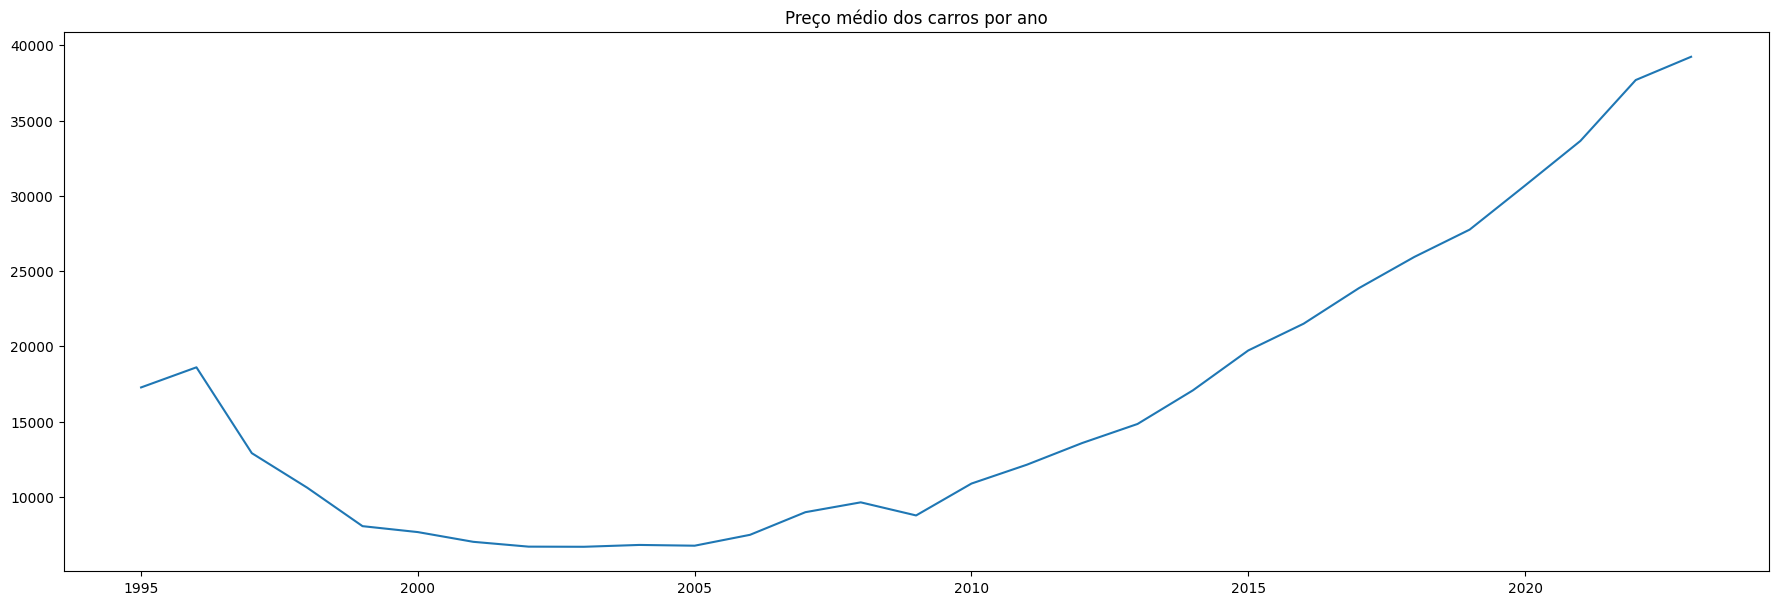

In [94]:
plt.figure(figsize = (22, 7))

plt.plot(serie['year'], serie['preco_medio'])

plt.ticklabel_format(style = 'plain', axis = 'y')

plt.title("Preço médio dos carros por ano");

O comportamento da variável `Year` é o mesmo que da variável `registration_date`, mas com menos captura de variabilidade, o que já era esperado.

Por fim, a última alteração a ser feita é a extração do mês da coluna `registration_date`, e exclusão da variável já que ela comprime muitas informações que podem ser dissecadas.

In [95]:
dados['month'] = dados['registration_date'].dt.month

dados.drop('registration_date', axis = 1, inplace = True)

In [96]:
dados

,brand,model,color,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km,boxcox_price_in_euro,log_power_kw,sqrt_mileage_in_km,month
,,,,,,,,,,,,,,,
0,alfa-romeo,Alfa Romeo GTV,red,1995,1300.0,148,201,Manual,Petrol,10.90,160500.0,10.435385,4.997212,400.624512,10
1,alfa-romeo,Alfa Romeo 164,black,1995,24900.0,191,260,Manual,Petrol,10.30,190000.0,17.401157,5.252273,435.889894,2
2,alfa-romeo,Alfa Romeo Spider,black,1995,5900.0,110,150,Unknown,Petrol,9.20,129000.0,13.750141,4.700480,359.165700,2
3,alfa-romeo,Alfa Romeo Spider,black,1995,4900.0,110,150,Manual,Petrol,9.50,189500.0,13.315961,4.700480,435.315977,7
4,alfa-romeo,Alfa Romeo 164,red,1996,17950.0,132,179,Manual,Petrol,7.20,96127.0,16.525102,4.882802,310.043545,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251074,volvo,Volvo XC40,white,2023,57990.0,192,261,Automatic,Hybrid,6.20,1229.0,19.799776,5.257495,35.057096,4
251075,volvo,Volvo XC90,white,2023,89690.0,173,235,Automatic,Diesel,7.60,4900.0,21.117700,5.153292,70.000000,3
251076,volvo,Volvo V60,white,2023,61521.0,145,197,Automatic,Diesel,4.70,1531.0,19.975097,4.976734,39.127995,5


In [97]:
dados.corr(numeric_only = True)

,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,mileage_in_km,boxcox_price_in_euro,log_power_kw,sqrt_mileage_in_km,month
year,1.000000,0.470719,0.074380,0.074531,-0.189231,-0.720718,0.706238,0.098290,-0.759850,-0.079136
price_in_euro,0.470719,1.000000,0.698558,0.698612,0.233524,-0.424499,0.866773,0.642888,-0.450099,-0.038504
power_kw,0.074380,0.698558,1.000000,0.999994,0.392148,-0.023566,0.593426,0.944633,-0.009286,0.002895
power_ps,0.074531,0.698612,0.999994,1.000000,0.392102,-0.023669,0.593501,0.944656,-0.009401,0.002862
fuel_consumption_l_100km,-0.189231,0.233524,0.392148,0.392102,1.000000,0.085418,0.110976,0.347819,0.070592,-0.016080
mileage_in_km,-0.720718,-0.424499,-0.023566,-0.023669,0.085418,1.000000,-0.587233,-0.000233,0.940285,0.039108
boxcox_price_in_euro,0.706238,0.866773,0.593426,0.593501,0.110976,-0.587233,1.000000,0.617013,-0.593275,-0.035630
log_power_kw,0.098290,0.642888,0.944633,0.944656,0.347819,-0.000233,0.617013,1.000000,0.010744,0.004462
sqrt_mileage_in_km,-0.759850,-0.450099,-0.009286,-0.009401,0.070592,0.940285,-0.593275,0.010744,1.000000,0.063581
month,-0.079136,-0.038504,0.002895,0.002862,-0.016080,0.039108,-0.035630,0.004462,0.063581,1.000000


As colunas `power_kw`e `power_ps` apresentam uma altissima correlação, o que é negativo para construção do modelo. Talvez seja melhor excluir uma delas.

Apenas a variável `month` não apresenta uma correlação consideravelmente alta com a variável `price_in_euro`, todas demais variáveis possuem. 

Em paralelo, a variável as correlações das variáveis com `boxcox_price_in_euro` tiveram uma diminuição quando comparadas com a `price_in_euro`. A variável mais afetada por essa diminuição foi a `mileage_in_km`.

In [98]:
print("Perda percentual do dataset:", round(100 - len(dados) / tamanho_dataset_inicio * 100, 2), "%")

Perda percentual do dataset: 1.38 %


## **Pré-processamento**

**Observação:** O uso de One Hot Encoding, durante as experimentações, favoreceu drasticamente os resultados do algoritmo Random Forest Regressor, gerando os melhores resultados dentre os modelos, com uma acurácia e variancia explicada de 0.92. No entanto, devido ao grande volume de categorias em algumas variáveis, cria problemas de memória e árvores muito esparsas, por essa razão o One Hot Enconding foi removido do processo e substituido pelo Leave One Out.

In [99]:
dados.head(5)

,brand,model,color,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km,boxcox_price_in_euro,log_power_kw,sqrt_mileage_in_km,month
,,,,,,,,,,,,,,,
0,alfa-romeo,Alfa Romeo GTV,red,1995,1300.0,148,201,Manual,Petrol,10.9,160500.0,10.435385,4.997212,400.624512,10
1,alfa-romeo,Alfa Romeo 164,black,1995,24900.0,191,260,Manual,Petrol,10.3,190000.0,17.401157,5.252273,435.889894,2
2,alfa-romeo,Alfa Romeo Spider,black,1995,5900.0,110,150,Unknown,Petrol,9.2,129000.0,13.750141,4.700480,359.165700,2
3,alfa-romeo,Alfa Romeo Spider,black,1995,4900.0,110,150,Manual,Petrol,9.5,189500.0,13.315961,4.700480,435.315977,7
4,alfa-romeo,Alfa Romeo 164,red,1996,17950.0,132,179,Manual,Petrol,7.2,96127.0,16.525102,4.882802,310.043545,11


In [100]:
dados['fuel_type'].value_counts()

fuel_type
Petrol      140558
Diesel       86099
Hybrid       12963
Electric      5918
LPG           1231
CNG            508
Other          173
Unknown         82
Hydrogen        78
Ethanol         10
Name: count, dtype: int64

In [101]:
for i in list(dados.select_dtypes(['object']).columns):
    print("Quantidade de valores únicos na coluna {}: {}".format(i, dados[i].nunique()))

Quantidade de valores únicos na coluna brand: 47
Quantidade de valores únicos na coluna model: 1281
Quantidade de valores únicos na coluna color: 14
Quantidade de valores únicos na coluna transmission_type: 4
Quantidade de valores únicos na coluna fuel_type: 10


Será aplicado Leave One Out para as colunas`brand`, `model`, `color`, `transmission_type` e `fuel_type`, uma vez que os dados não são ordinais, então não é adequado a aplciação do LabelEncoder, e o OneHotEncoding pode gerar problemas de memória em arvores de decisão.

In [102]:
dataset_modelo = dados[['brand', 'model', 'color', 'year', 'fuel_consumption_l_100km', 'boxcox_price_in_euro', 
                        'log_power_kw', 'sqrt_mileage_in_km', 'month', 'transmission_type', 'fuel_type']]

In [103]:
X = dataset_modelo.drop('boxcox_price_in_euro', axis = 1)
Y = dataset_modelo['boxcox_price_in_euro']

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [104]:
looe_encoder = ce.LeaveOneOutEncoder()

train_looe = looe_encoder.fit_transform(X_treino[['brand', 'model', 'color', 'transmission_type', 'fuel_type']], Y_treino)
test_looe = looe_encoder.transform(X_teste[['brand', 'model', 'color', 'transmission_type', 'fuel_type']])

X_treino[['brand', 'model', 'color', 'transmission_type', 'fuel_type']] = train_looe
X_teste[['brand', 'model', 'color', 'transmission_type', 'fuel_type']] = test_looe

## **Construção e Comparação dos Modelos**

In [105]:
scaler = StandardScaler()

scaler.fit(X_treino)

X_treino = scaler.transform(X_treino)

X_teste = scaler.transform(X_teste)

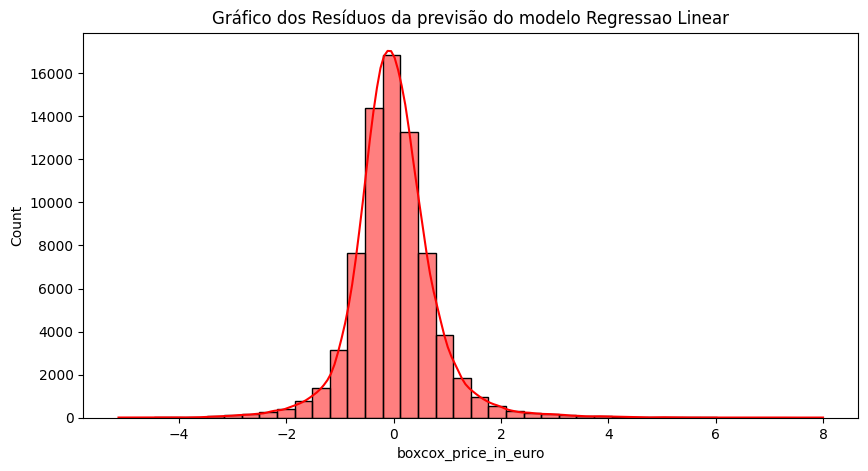

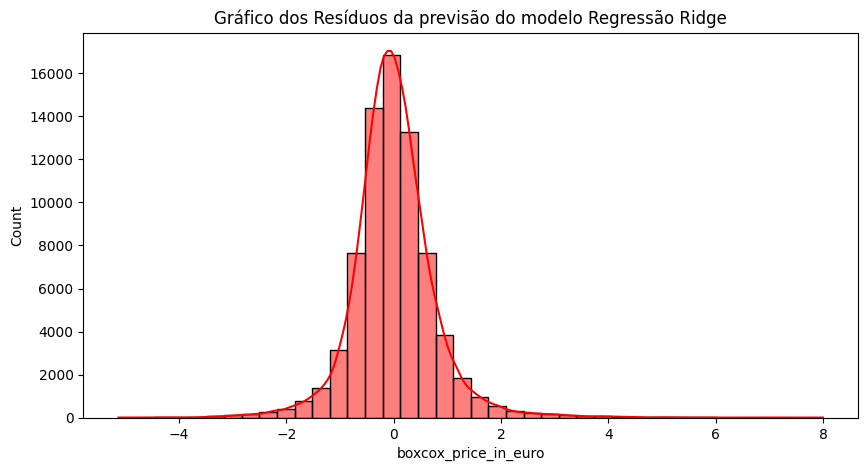

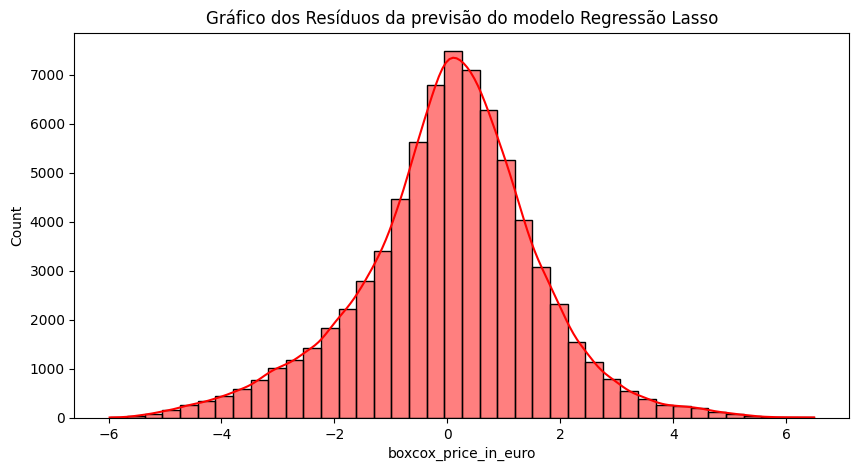

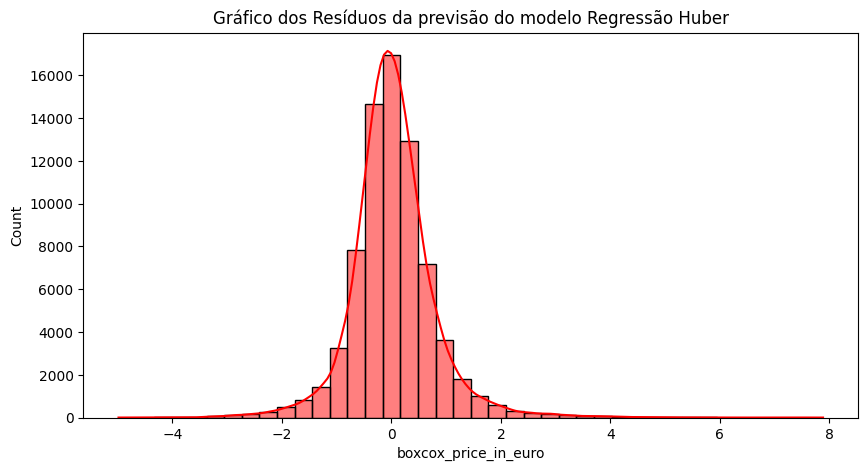

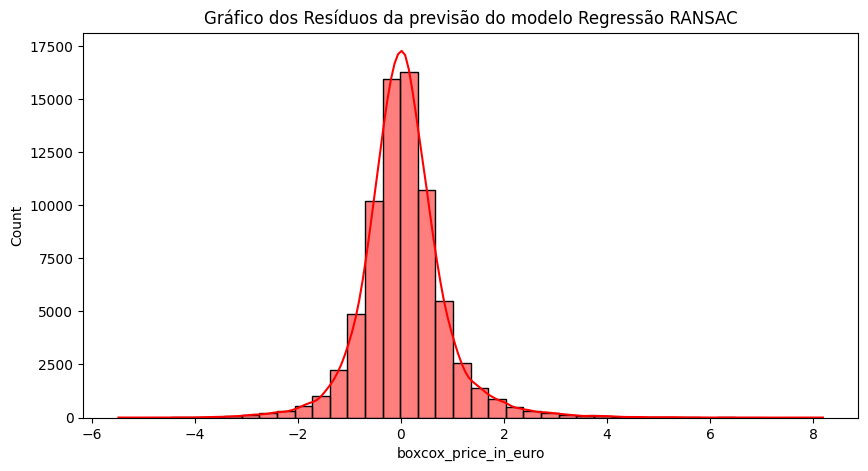

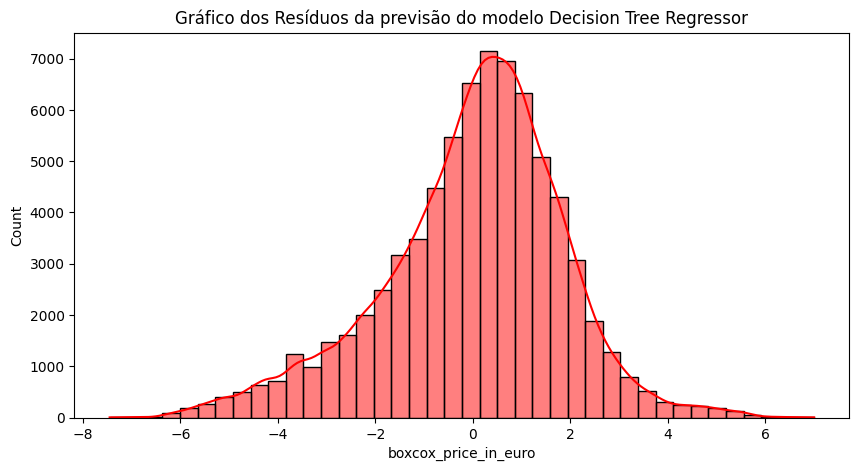

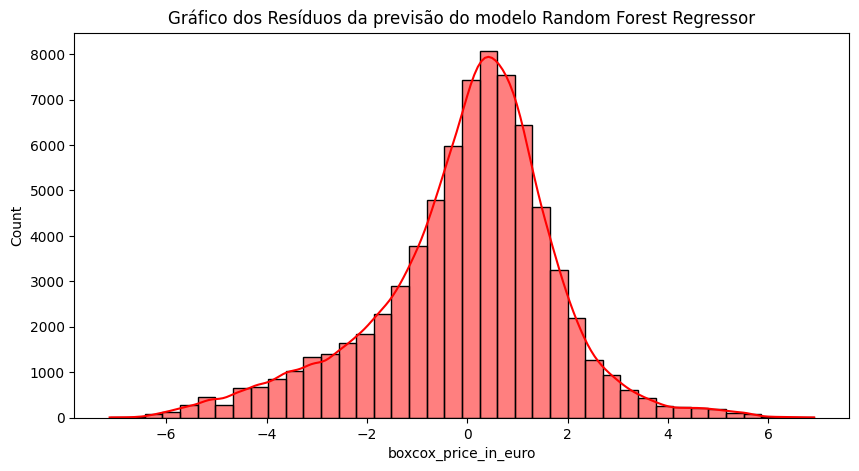

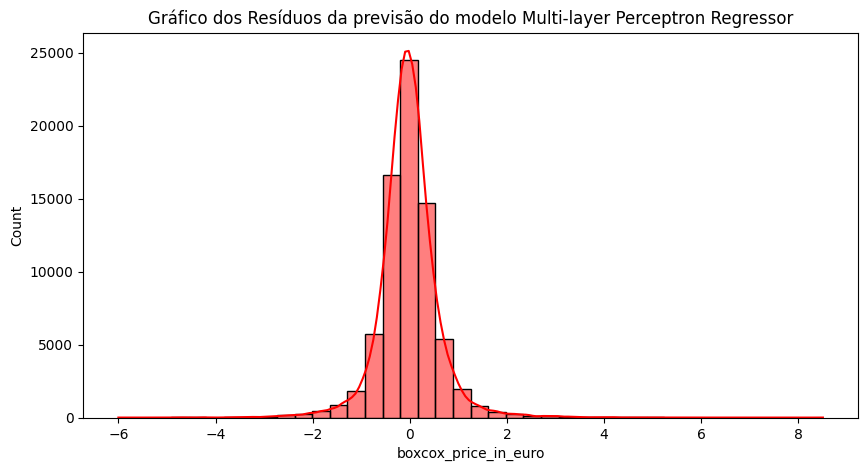

In [106]:
linear_reg = LinearRegression()
ridge_reg = Ridge(random_state = 42)
lasso_reg = Lasso(random_state = 42)
huber_reg = HuberRegressor()
RANSAC_reg = RANSACRegressor(random_state = 42)
decision_tree_reg = DecisionTreeRegressor(random_state = 42)
random_forest_reg = RandomForestRegressor(random_state = 42)
mlp_reg = MLPRegressor(random_state = 42)

metricas_comparacao = pd.DataFrame(index = ["mae", "mse", "rmse", "r2", "var_exp"])

modelos = ['Regressao Linear', 'Regressão Ridge', 'Regressão Lasso', 'Regressão Huber', 'Regressão RANSAC', 'Decision Tree Regressor', 'Random Forest Regressor', 'Multi-layer Perceptron Regressor']

for x, i in enumerate([linear_reg, ridge_reg, lasso_reg, huber_reg, RANSAC_reg, decision_tree_reg, random_forest_reg, mlp_reg]):
    
    i.fit(X_treino, Y_treino)
    prev = i.predict(X_teste)
        
    mae = mean_absolute_error(Y_teste, prev)
    mse = mean_squared_error(Y_teste, prev)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_teste, prev)
    var_exp = explained_variance_score(Y_teste, prev)
    
    metricas_comparacao[modelos[x]] = [mae, mse, rmse, r2, var_exp]
    
    plt.figure(figsize = (10, 5))

    ax = sns.histplot((Y_teste - prev),
                      bins = 40,
                      color = 'red',
                      kde = True)
    
    plt.title("Gráfico dos Resíduos da previsão do modelo " + modelos[x])
    
    plt.show();

Em todos os casos os resíduos possuem uma distribuição semelhante a uma curva normal.

In [107]:
metricas_comparacao

,Regressao Linear,Regressão Ridge,Regressão Lasso,Regressão Huber,Regressão RANSAC,Decision Tree Regressor,Random Forest Regressor,Multi-layer Perceptron Regressor
mae,0.537975,0.537975,1.189748,0.533792,0.567621,1.429894,1.339251,0.422192
mse,0.582575,0.582575,2.470897,0.587088,0.655546,3.474219,3.206988,0.388449
rmse,0.763266,0.763266,1.571909,0.766217,0.809658,1.863926,1.790807,0.623257
r2,0.861929,0.861929,0.414394,0.860859,0.844635,0.176606,0.239940,0.907937
var_exp,0.861929,0.861929,0.414426,0.861063,0.845203,0.176606,0.240116,0.908083


Dado os resultados, o melhor modelo para se conduzir a otimização é o Multi-layer Percepton Regressor. No entanto, deve-se levar em consideração o custo computacional. Dessa forma, poderia ser uma boa opção a escolha pelo modelo de Regressão Linear.

Feito este adendo, a otmização será realizada utilizando a Multi-layer Percepton Regressor, utilizando o Grid Search CV, com poucos parâmetros. Já que não cabem otimizações no moelo de Regressão Linear, e o objetivo é não demorar horas para realizar a otimização.

## **Otimização**

In [108]:
pprint(mlp_reg.get_params(deep=True))

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


In [109]:
param_grid = {'hidden_layer_sizes': [(95,), (100,), (105,)],
              'alpha': [0.0001, 0.0002, 0.00008],
              'learning_rate': ['constant','adaptive']}

In [110]:
mlp_reg = MLPRegressor(random_state = 42, max_iter = 600, tol = 0.0001)

mlp_reg_grid = GridSearchCV(mlp_reg, param_grid, verbose = 1, cv = 3, n_jobs = -1)

mlp_reg_grid.fit(X_treino, Y_treino)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=600, random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0002, 8e-05],
                         'hidden_layer_sizes': [(95,), (100,), (105,)],
                         'learning_rate': ['constant', 'adaptive']},
             verbose=1)

In [111]:
melhor_mlp = mlp_reg_grid.best_estimator_

prev = melhor_mlp.predict(X_teste)

mae = mean_absolute_error(Y_teste, prev)
mse = mean_squared_error(Y_teste, prev)
rmse = np.sqrt(mse)
r2 = r2_score(Y_teste, prev)
var_exp = explained_variance_score(Y_teste, prev)

metricas_comparacao['MLP_grid_search_cv'] = [mae, mse, rmse, r2, var_exp]

In [112]:
mlp_reg_grid.best_params_

{'alpha': 0.0001, 'hidden_layer_sizes': (105,), 'learning_rate': 'constant'}

In [113]:
metricas_comparacao

,Regressao Linear,Regressão Ridge,Regressão Lasso,Regressão Huber,Regressão RANSAC,Decision Tree Regressor,Random Forest Regressor,Multi-layer Perceptron Regressor,MLP_grid_search_cv
mae,0.537975,0.537975,1.189748,0.533792,0.567621,1.429894,1.339251,0.422192,0.428061
mse,0.582575,0.582575,2.470897,0.587088,0.655546,3.474219,3.206988,0.388449,0.393240
rmse,0.763266,0.763266,1.571909,0.766217,0.809658,1.863926,1.790807,0.623257,0.627088
r2,0.861929,0.861929,0.414394,0.860859,0.844635,0.176606,0.239940,0.907937,0.906802
var_exp,0.861929,0.861929,0.414426,0.861063,0.845203,0.176606,0.240116,0.908083,0.907331


O tunning dos modelos não gerou grandes melhorias no seu resultado final. Logo, o Multi-layer Perceptron Regressor se manteve o melhor modelo para utilização. 

No entanto, como já citado anteriormente, deve-se levar em consideração outros fatores, como custo computacional, complexidade do modelo e a diferença na performance do modelo em relação a natureza do próprio problema. Por exemplo, a diferença de 4% no R² em um modelo na área da saúde pode ser de grande valia, uma vez que pode existir o risco de morte por erros. 

As possibilidade utilizadas para otimização foram aqui reduzidas, o modelo provavelmente possui alguma margem para melhorias, não somente por esse meio, mas também por seleção de variáveis, por exemplo.